Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. We have tested this notebook on a server with 4 NVidia V100 GPU (32GB) and 400GB CPU Ram.

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `nlp,ray,notebook` and `blendsearch` option:
```bash
pip install flaml[nlp,ray,notebook,blendsearch];
```

In [1]:
%pip install flaml[nlp,ray,notebook,blendsearch]

Let's run some examples. 

Note: throughout this notebook, you may see a few ModuleNotFoundErrors. As long as the cell successfully executes, you can ignore that error.

## 2. Sentiment Classification Example
### Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "mrpc", split="train").to_pandas()
dev_dataset = load_dataset("glue", "mrpc", split="validation").to_pandas()
test_dataset = load_dataset("glue", "mrpc", split="test").to_pandas()

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Take a look at the first 5 examples of this dataset:

In [3]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [2]:
custom_sent_keys = ["sentence1", "sentence2"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
if not ray.is_initialized():
    ray.init() 

/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


OSError: [Errno 28] No space left on device: '/tmp/ray/session_2022-07-21_13-06-39_130205_51211'

In [4]:
TIME_BUDGET=1200
automl_settings = {
    "time_budget": TIME_BUDGET,                  # setting the time budget
    "task": "seq-classification",       # setting the task as seq-classification
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   # setting the output directory
            "ckpt_per_epoch": 1,            # setting the number of checkoints per epoch
            "model_path": "bert-base-uncased",  # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4,
    "keep_search_state": True,          # keeping the search state
}

In [6]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=59250) {'loss': 0.3327, 'learning_rate': 1.0295123460382672e-05, 'epoch': 2.18}
(train pid=59407) {'loss': 0.4744, 'learning_rate': 3.8483947490148965e-06, 'epoch': 1.64}
(train pid=58929) {'loss': 0.1645, 'learning_rate': 4.8933330345560835e-06, 'epoch': 3.27}
(train pid=59592) {'loss': 0.5619, 'learning_rate': 1.3544721826857925e-05, 'epoch': 0.55}
(train pid=59407) {'eval_loss': 0.5415804386138916, 'eval_automl_metric': 0.13480392156862742, 'eval_runtime': 3.8874, 'eval_samples_per_second': 104.956, 'eval_steps_per_second': 104.956, 'epoch': 2.0}
(train pid=59407) {'train_runtime': 133.4439, 'train_samples_per_second': 54.974, 'train_steps_per_second': 13.744, 'train_loss': 0.4956582546754128, 'epoch': 2.0}
(train pid=59250) {'loss': 0.2012, 'learning_rate': 7.209055276814724e-06, 'epoch': 2.73}


(train pid=59407) ***** Running Prediction *****
(train pid=59407)   Num examples = 408
(train pid=59407)   Batch size = 1
(train pid=59407) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_5c51b244_32_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-26-12/checkpoint-1834/added_tokens.json. We won't load it.
(train pid=59407) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_5c51b244_32_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-26-12/checkpoint-1834/vocab.txt
(train pid=59407) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_5c51b244_32_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13

(train pid=59592) {'eval_loss': 0.5180040001869202, 'eval_automl_metric': 0.15931372549019607, 'eval_runtime': 3.7749, 'eval_samples_per_second': 108.082, 'eval_steps_per_second': 108.082, 'epoch': 1.0}
(train pid=58929) {'loss': 0.0951, 'learning_rate': 1.2306586074931466e-06, 'epoch': 3.82}
(train pid=59592) {'loss': 0.4703, 'learning_rate': 8.46798950794566e-06, 'epoch': 1.09}
(train pid=59250) {'eval_loss': 0.6077207326889038, 'eval_automl_metric': 0.11764705882352944, 'eval_runtime': 3.8401, 'eval_samples_per_second': 106.247, 'eval_steps_per_second': 106.247, 'epoch': 3.0}
(train pid=58929) {'eval_loss': 0.806081235408783, 'eval_automl_metric': 0.13480392156862742, 'eval_runtime': 3.7716, 'eval_samples_per_second': 108.177, 'eval_steps_per_second': 108.177, 'epoch': 4.0}
(train pid=58929) {'train_runtime': 256.0423, 'train_samples_per_second': 57.303, 'train_steps_per_second': 14.326, 'train_loss': 0.35705690737509027, 'epoch': 4.0}


(train pid=58929) ***** Running Prediction *****
(train pid=58929)   Num examples = 408
(train pid=58929)   Batch size = 1
(train pid=58929) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_227f7ab0_29_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13-24-35/checkpoint-3668/added_tokens.json. We won't load it.
(train pid=58929) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_227f7ab0_29_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13-24-35/checkpoint-3668/vocab.txt
(train pid=58929) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_227f7ab0_29_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13

(train pid=59250) {'loss': 0.1476, 'learning_rate': 4.122987093246777e-06, 'epoch': 3.27}
(train pid=59592) {'loss': 0.3574, 'learning_rate': 3.391257189033394e-06, 'epoch': 1.64}
(train pid=59592) {'eval_loss': 0.5781316757202148, 'eval_automl_metric': 0.1421568627450981, 'eval_runtime': 3.7277, 'eval_samples_per_second': 109.45, 'eval_steps_per_second': 109.45, 'epoch': 2.0}
(train pid=59592) {'train_runtime': 128.6158, 'train_samples_per_second': 57.038, 'train_steps_per_second': 14.26, 'train_loss': 0.4407762508745932, 'epoch': 2.0}


(train pid=59592) ***** Running Prediction *****
(train pid=59592)   Num examples = 408
(train pid=59592)   Batch size = 1


(train pid=59250) {'loss': 0.1029, 'learning_rate': 1.03691890967883e-06, 'epoch': 3.82}


(train pid=59592) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_89b0b9a7_33_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-27-29/checkpoint-1834/added_tokens.json. We won't load it.
(train pid=59592) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_89b0b9a7_33_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-27-29/checkpoint-1834/vocab.txt
(train pid=59592) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_89b0b9a7_33_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-27-29/checkpoint-1834/tokenizer.json
(train pid=59592) loading file None
(train pid=59592) loading file /data/xliu127/proj

(train pid=59250) {'eval_loss': 0.7132703065872192, 'eval_automl_metric': 0.12254901960784315, 'eval_runtime': 3.735, 'eval_samples_per_second': 109.237, 'eval_steps_per_second': 109.237, 'epoch': 4.0}
(train pid=59250) {'train_runtime': 264.9924, 'train_samples_per_second': 55.368, 'train_steps_per_second': 13.842, 'train_loss': 0.31339427247042223, 'epoch': 4.0}


(train pid=59250) ***** Running Prediction *****
(train pid=59250)   Num examples = 408
(train pid=59250)   Batch size = 1
(train pid=59250) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_45d8f8ce_31_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13-25-34/checkpoint-2751/added_tokens.json. We won't load it.
(train pid=59250) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_45d8f8ce_31_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13-25-34/checkpoint-2751/vocab.txt
(train pid=59250) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_45d8f8ce_31_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13

{'loss': 0.405, 'learning_rate': 6.02286555920107e-06, 'epoch': 2.17}


[flaml.automl: 07-21 13:32:01] {3457} INFO - retrain transformer for 101.3s
[flaml.automl: 07-21 13:32:01] {3464} INFO - retrained model: None
[flaml.automl: 07-21 13:32:01] {2742} INFO - fit succeeded
[flaml.automl: 07-21 13:32:01] {2743} INFO - Time taken to find the best model: 1019.1050026416779
[flaml.automl: 07-21 13:32:01] {2754} WARNING - Time taken to find the best model is 85% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


{'train_runtime': 93.2817, 'train_samples_per_second': 117.965, 'train_steps_per_second': 7.397, 'train_loss': 0.3405460468236951, 'epoch': 3.0}


In [7]:
print("The best loss by FLAML: {}".format(automl.best_loss))

The best loss by FLAML: 0.12009803921568629


### Best model and metric

In [6]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'learning_rate': 1.4736175808553141e-05, 'num_train_epochs': 7.623375372739029, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.21605876280261357, 'weight_decay': 0.11938244526496489, 'adam_epsilon': 7.353322403647365e-07, 'seed': 42, 'global_max_steps': 1878, 'learner': 'transformer'}
Best accuracy on validation data: 0.9404
Training duration of best run: 157.7 s


In [8]:
import pickle
automl.pickle("automl.pkl")

with open("automl.pkl", "rb") as f:
    automl = pickle.load(f)

/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.528, 'learning_rate': 8.898933352349567e-06, 'epoch': 1.0}
{'eval_loss': 0.2549280524253845, 'eval_automl_metric': 0.08600917431192656, 'eval_runtime': 1.0003, 'eval_samples_per_second': 871.751, 'eval_steps_per_second': 54.984, 'epoch': 1.0}
{'loss': 0.2278, 'learning_rate': 1.3880017803076292e-05, 'epoch': 2.0}
{'eval_loss': 0.24966619908809662, 'eval_automl_metric': 0.06766055045871555, 'eval_runtime': 1.0201, 'eval_samples_per_second': 854.778, 'eval_steps_per_second': 53.914, 'epoch': 2.0}
{'loss': 0.1455, 'learning_rate': 1.1410179501562432e-05, 'epoch': 3.0}
{'eval_loss': 0.23046882450580597, 'eval_automl_metric': 0.059633027522935755, 'eval_runtime': 1.0097, 'eval_samples_per_second': 863.6, 'eval_steps_per_second': 54.47, 'epoch': 3.0}
{'eval_loss': 0.23046882450580597, 'eval_automl_metric': 0.059633027522935755, 'eval_runtime': 0.9726, 'eval_samples_per_second': 896.568, 'eval_steps_per_second': 56.55, 'epoch': 3.0}
{'train_runtime': 146.7879, 'train_samples_per_se

Using amp half precision backend
***** Running Prediction *****
  Num examples = 872
  Batch size = 64


In [9]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test, **{"per_device_eval_batch_size": 1})
print('Predicted labels', y_pred)

Using amp half precision backend
***** Running Prediction *****
  Num examples = 1821
  Batch size = 4


Predicted labels [0 0 1 ... 1 1 1]


### Comparing with Transformers

In Transformers, we can tune the hyperparameters using Trainer.hyperparameter_search. The code for tuning sequence classification looks like below:

In [7]:
from datasets import load_dataset, load_metric
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
dataset = load_dataset('glue', 'mrpc')
metric = load_metric('glue', 'mrpc')

def encode(examples):
    outputs = tokenizer(
        examples['sentence1'], examples['sentence2'], truncation=True)
    return outputs

encoded_dataset = dataset.map(encode, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        'bert-base-uncased', return_dict=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Evaluate during training and a bit more often
# than the default to be able to prune bad trials early.
# Disabling tqdm is a matter of preference.
training_args = TrainingArguments(
    "test", evaluation_strategy="steps", eval_steps=500, disable_tqdm=True)
trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    model_init=model_init,
    compute_metrics=compute_metrics,
)

# Default objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
trainer.hyperparameter_search(
    time_budget_s=TIME_BUDGET,
    direction="maximize", 
    backend="ray", 
    n_trials=-1, # number of trials,
    keep_checkpoints_num=1
)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/xliu127/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/re

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/xliu127/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2022-07-21 12:41:38,713	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
== Status ==
Current time: 2

(_objective pid=42694) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
(_objective pid=42694) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=42694) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=42694) Som

== Status ==
Current time: 2022-07-21 12:41:50 (running for 00:00:08.02)
Memory usage on this node: 19.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 109/infinite (105 PENDING, 4 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_25571_00000 | RUNNING  | 155.246.89.124:42694 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_25571_00001 | RUN

(_objective pid=42735) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=42735)   warnings.warn(
(_objective pid=42737) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=42737)   warnings.warn(
(_objective pid=42733) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

== Status ==
Current time: 2022-07-21 12:41:55 (running for 00:00:13.05)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 109/infinite (105 PENDING, 4 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_25571_00000 | RUNNING  | 155.246.89.124:42694 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_25571_00001 | RUN

== Status ==
Current time: 2022-07-21 12:42:10 (running for 00:00:28.10)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 109/infinite (105 PENDING, 4 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_25571_00000 | RUNNING  | 155.246.89.124:42694 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_25571_00001 | RUN

== Status ==
Current time: 2022-07-21 12:42:25 (running for 00:00:43.16)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 109/infinite (105 PENDING, 4 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_25571_00000 | RUNNING  | 155.246.89.124:42694 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_25571_00001 | RUN

(_objective pid=42873) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
(_objective pid=42873) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=42873) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=42873) Som

== Status ==
Current time: 2022-07-21 12:42:36 (running for 00:00:54.33)
Memory usage on this node: 20.6/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 111/infinite (105 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00000 | RUNNING    | 155.246.89.124:42694 |     5.61152e-06 |                  5 |          

(_objective pid=42873) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=42873)   warnings.warn(
(_objective pid=42870) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=42870)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:42:41 (running for 00:00:59.35)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 111/infinite (105 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00000 | RUNNING    | 155.246.89.124:42694 |     5.61152e-06 |                  5 |          

== Status ==
Current time: 2022-07-21 12:42:51 (running for 00:01:09.38)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 111/infinite (105 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00000 | RUNNING    | 155.246.89.124:42694 |     5.61152e-06 |                  5 |          

== Status ==
Current time: 2022-07-21 12:43:01 (running for 00:01:19.42)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 111/infinite (105 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00000 | RUNNING    | 155.246.89.124:42694 |     5.61152e-06 |                  5 |          

Result for _objective_25571_00000:
  date: 2022-07-21_12-43-07
  done: false
  epoch: 4.35
  eval_accuracy: 0.7916666666666666
  eval_f1: 0.8580968280467446
  eval_loss: 0.5054973363876343
  eval_runtime: 0.7008
  eval_samples_per_second: 582.223
  eval_steps_per_second: 72.778
  experiment_id: 7fd6dc97674d4a47a7510b4727dc442c
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6497634947134112
  pid: 42694
  should_checkpoint: true
  time_since_restore: 82.52964782714844
  time_this_iter_s: 82.52964782714844
  time_total_s: 82.52964782714844
  timestamp: 1658432587
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00000'
  warmup_time: 0.004468441009521484
  
(_objective pid=42735) {'loss': 0.4409, 'learning_rate': 1.0811630695937156e-06, 'epoch': 4.35}
(_objective pid=42735) {'eval_loss': 0.4387318193912506, 'eval_accuracy': 0.821078431372549, 'eval_f1': 0.8764805414551609, 'eval_runtime': 0.7109, 'eval_samples_per_second': 5

(_objective pid=42694) {'train_runtime': 90.5279, 'train_samples_per_second': 202.59, 'train_steps_per_second': 6.352, 'train_loss': 0.4895707370923913, 'epoch': 5.0}
Result for _objective_25571_00000:
  date: 2022-07-21_12-43-07
  done: true
  epoch: 4.35
  eval_accuracy: 0.7916666666666666
  eval_f1: 0.8580968280467446
  eval_loss: 0.5054973363876343
  eval_runtime: 0.7008
  eval_samples_per_second: 582.223
  eval_steps_per_second: 72.778
  experiment_id: 7fd6dc97674d4a47a7510b4727dc442c
  experiment_tag: 0_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=64,seed=8.1540
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6497634947134112
  pid: 42694
  should_checkpoint: true
  time_since_restore: 82.52964782714844
  time_this_iter_s: 82.52964782714844
  time_total_s: 82.52964782714844
  timestamp: 1658432587
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00000'
  warmup_time: 0.004468441009521484
  
== 

(_objective pid=42977) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=42977) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=42977) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=42977) Som

== Status ==
Current time: 2022-07-21 12:43:30 (running for 00:01:48.38)
Memory usage on this node: 22.5/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 113/infinite (105 PENDING, 4 RUNNING, 4 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00004 | RUNNING    | 155.246.89.124:42870 |     2.3102e-06  |                  5 |          

(_objective pid=43013) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43013)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:43:35 (running for 00:01:53.39)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 113/infinite (105 PENDING, 4 RUNNING, 4 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00004 | RUNNING    | 155.246.89.124:42870 |     2.3102e-06  |                  5 |          

== Status ==
Current time: 2022-07-21 12:43:45 (running for 00:02:03.42)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 113/infinite (105 PENDING, 4 RUNNING, 4 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00004 | RUNNING    | 155.246.89.124:42870 |     2.3102e-06  |                  5 |          

(_objective pid=42873) {'train_runtime': 72.912, 'train_samples_per_second': 201.229, 'train_steps_per_second': 6.309, 'train_loss': 0.4509672081988791, 'epoch': 4.0}
(_objective pid=42873) {'eval_loss': 0.5211783647537231, 'eval_accuracy': 0.803921568627451, 'eval_f1': 0.8648648648648648, 'eval_runtime': 0.7072, 'eval_samples_per_second': 576.909, 'eval_steps_per_second': 72.114, 'epoch': 4.0}
Result for _objective_25571_00005:
  date: 2022-07-21_12-43-54
  done: true
  epoch: 4.0
  eval_accuracy: 0.803921568627451
  eval_f1: 0.8648648648648648
  eval_loss: 0.5211783647537231
  eval_runtime: 0.7072
  eval_samples_per_second: 576.909
  eval_steps_per_second: 72.114
  experiment_id: 22fdd550a0e0448b80b5daa73c4cc23b
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6687864334923157
  pid: 42873
  should_checkpoint: true
  time_since_restore: 80.81901454925537
  time_this_iter_s: 80.81901454925537
  time_total_s: 80.81901454925537
  timestamp: 165843

(_objective pid=43068) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=43068) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43068) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43068) Som

== Status ==
Current time: 2022-07-21 12:44:02 (running for 00:02:20.60)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 114/infinite (105 PENDING, 4 RUNNING, 5 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00004 | RUNNING    | 155.246.89.124:42870 |     2.3102e-06  |                  5 |          

(_objective pid=43068) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43068)   warnings.warn(


(_objective pid=42977) {'train_runtime': 35.1259, 'train_samples_per_second': 208.849, 'train_steps_per_second': 6.548, 'train_loss': 0.4949451612389606, 'epoch': 2.0}
(_objective pid=42977) {'eval_loss': 0.45492023229599, 'eval_accuracy': 0.8137254901960784, 'eval_f1': 0.8733333333333333, 'eval_runtime': 0.7005, 'eval_samples_per_second': 582.452, 'eval_steps_per_second': 72.806, 'epoch': 2.0}
Result for _objective_25571_00006:
  date: 2022-07-21_12-44-06
  done: true
  epoch: 2.0
  eval_accuracy: 0.8137254901960784
  eval_f1: 0.8733333333333333
  eval_loss: 0.45492023229599
  eval_runtime: 0.7005
  eval_samples_per_second: 582.452
  eval_steps_per_second: 72.806
  experiment_id: d6f4b90cd1e14df38ce19be9cdd7e92a
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6870588235294117
  pid: 42977
  should_checkpoint: true
  time_since_restore: 42.65422701835632
  time_this_iter_s: 42.65422701835632
  time_total_s: 42.65422701835632
  timestamp: 1658432

(_objective pid=43113) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
(_objective pid=43113) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43113) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43113) Som

== Status ==
Current time: 2022-07-21 12:44:16 (running for 00:02:34.42)
Memory usage on this node: 22.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 116/infinite (105 PENDING, 4 RUNNING, 7 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00007 | RUNNING    | 155.246.89.124:43013 |     5.4041e-06  |                  3 |          

(_objective pid=43149) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
(_objective pid=43149) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43149) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43149) Som

== Status ==
Current time: 2022-07-21 12:44:21 (running for 00:02:39.43)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 116/infinite (105 PENDING, 4 RUNNING, 7 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00007 | RUNNING    | 155.246.89.124:43013 |     5.4041e-06  |                  3 |          

(_objective pid=43013) {'train_runtime': 53.972, 'train_samples_per_second': 203.884, 'train_steps_per_second': 6.392, 'train_loss': 0.5804045746291893, 'epoch': 3.0}
(_objective pid=43013) {'eval_loss': 0.5164138078689575, 'eval_accuracy': 0.7426470588235294, 'eval_f1': 0.8314606741573034, 'eval_runtime': 0.7125, 'eval_samples_per_second': 572.597, 'eval_steps_per_second': 71.575, 'epoch': 3.0}
Result for _objective_25571_00007:
  date: 2022-07-21_12-44-29
  done: true
  epoch: 3.0
  eval_accuracy: 0.7426470588235294
  eval_f1: 0.8314606741573034
  eval_loss: 0.5164138078689575
  eval_runtime: 0.7125
  eval_samples_per_second: 572.597
  eval_steps_per_second: 71.575
  experiment_id: c5bb715252064e97807c311491f61261
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5741077329808328
  pid: 43013
  should_checkpoint: true
  time_since_restore: 61.81912851333618
  time_this_iter_s: 61.81912851333618
  time_total_s: 61.81912851333618
  timestamp: 1658

(_objective pid=43200) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
(_objective pid=43200) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43200) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43200) Som

== Status ==
Current time: 2022-07-21 12:44:34 (running for 00:02:52.50)
Memory usage on this node: 22.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 117/infinite (105 PENDING, 4 RUNNING, 8 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00008 | RUNNING    | 155.246.89.124:43068 |     1.53049e-05 |                  3 |          

(_objective pid=43200) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43200)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:44:39 (running for 00:02:57.53)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 117/infinite (105 PENDING, 4 RUNNING, 8 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00008 | RUNNING    | 155.246.89.124:43068 |     1.53049e-05 |                  3 |          

== Status ==
Current time: 2022-07-21 12:44:49 (running for 00:03:07.56)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 117/infinite (105 PENDING, 4 RUNNING, 8 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00008 | RUNNING    | 155.246.89.124:43068 |     1.53049e-05 |                  3 |          

(_objective pid=43247) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=43247) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43247) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43247) Som

Result for _objective_25571_00010:
  date: 2022-07-21_12-44-58
  done: true
  epoch: 2.0
  eval_accuracy: 0.7818627450980392
  eval_f1: 0.8548123980424144
  eval_loss: 0.48809701204299927
  eval_runtime: 0.7011
  eval_samples_per_second: 581.936
  eval_steps_per_second: 72.742
  experiment_id: 945685cf61b6420b87c9812e2fa4b9e4
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6366751431404536
  pid: 43149
  should_checkpoint: true
  time_since_restore: 44.982948541641235
  time_this_iter_s: 44.982948541641235
  time_total_s: 44.982948541641235
  timestamp: 1658432698
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00010'
  warmup_time: 0.004511594772338867
  


(_objective pid=43247) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43247)   warnings.warn(
(_objective pid=43293) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
(_objective pid=43293) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

== Status ==
Current time: 2022-07-21 12:45:04 (running for 00:03:22.47)
Memory usage on this node: 20.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00011 | RUNNING    | 155.246.89.124:43200 |     2.89593e-06 |                  4 |         

(_objective pid=43291) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
(_objective pid=43291) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43291) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43291) Som

== Status ==
Current time: 2022-07-21 12:45:09 (running for 00:03:27.49)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00011 | RUNNING    | 155.246.89.124:43200 |     2.89593e-06 |                  4 |         

== Status ==
Current time: 2022-07-21 12:45:19 (running for 00:03:37.52)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00011 | RUNNING    | 155.246.89.124:43200 |     2.89593e-06 |                  4 |         

== Status ==
Current time: 2022-07-21 12:45:29 (running for 00:03:47.54)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00011 | RUNNING    | 155.246.89.124:43200 |     2.89593e-06 |                  4 |         

== Status ==
Current time: 2022-07-21 12:45:39 (running for 00:03:57.58)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00011 | RUNNING    | 155.246.89.124:43200 |     2.89593e-06 |                  4 |         

(_objective pid=43200) {'train_runtime': 71.2568, 'train_samples_per_second': 205.903, 'train_steps_per_second': 6.456, 'train_loss': 0.5860705831776495, 'epoch': 4.0}
(_objective pid=43200) {'eval_loss': 0.5343301892280579, 'eval_accuracy': 0.7279411764705882, 'eval_f1': 0.82574568288854, 'eval_runtime': 0.7155, 'eval_samples_per_second': 570.201, 'eval_steps_per_second': 71.275, 'epoch': 4.0}
== Status ==
Current time: 2022-07-21 12:45:49 (running for 00:04:07.62)
Memory usage on this node: 24.0/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | sta

(_objective pid=43388) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(_objective pid=43388) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43388) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43388) Som

== Status ==
Current time: 2022-07-21 12:46:02 (running for 00:04:20.47)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 122/infinite (105 PENDING, 4 RUNNING, 13 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00013 | RUNNING    | 155.246.89.124:43291 |     2.31458e-06 |                  4 |         

(_objective pid=43428) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(_objective pid=43428) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43428) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43428) Som

== Status ==
Current time: 2022-07-21 12:46:07 (running for 00:04:25.49)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 122/infinite (105 PENDING, 4 RUNNING, 13 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00013 | RUNNING    | 155.246.89.124:43291 |     2.31458e-06 |                  4 |         

== Status ==
Current time: 2022-07-21 12:46:17 (running for 00:04:35.52)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 122/infinite (105 PENDING, 4 RUNNING, 13 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00013 | RUNNING    | 155.246.89.124:43291 |     2.31458e-06 |                  4 |         

(_objective pid=43478) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
(_objective pid=43478) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43478) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43478) Som

== Status ==
Current time: 2022-07-21 12:46:30 (running for 00:04:47.87)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 123/infinite (105 PENDING, 4 RUNNING, 14 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00014 | RUNNING    | 155.246.89.124:43293 |     1.36584e-05 |                  5 |         

(_objective pid=43388) {'train_runtime': 36.1574, 'train_samples_per_second': 202.891, 'train_steps_per_second': 6.361, 'train_loss': 0.557811106806216, 'epoch': 2.0}
(_objective pid=43388) {'eval_loss': 0.5090649127960205, 'eval_accuracy': 0.7622549019607843, 'eval_f1': 0.8422764227642278, 'eval_runtime': 0.7261, 'eval_samples_per_second': 561.88, 'eval_steps_per_second': 70.235, 'epoch': 2.0}
Result for _objective_25571_00015:
  date: 2022-07-21_12-46-38
  done: true
  epoch: 2.0
  eval_accuracy: 0.7622549019607843
  eval_f1: 0.8422764227642278
  eval_loss: 0.5090649127960205
  eval_runtime: 0.7261
  eval_samples_per_second: 561.88
  eval_steps_per_second: 70.235
  experiment_id: 88bab1cbdc7a4070824dc8d20857971a
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.604531324725012
  pid: 43388
  should_checkpoint: true
  time_since_restore: 43.95972514152527
  time_this_iter_s: 43.95972514152527
  time_total_s: 43.95972514152527
  timestamp: 1658432

(_objective pid=43529) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=43529) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43529) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43529) Som

== Status ==
Current time: 2022-07-21 12:46:43 (running for 00:05:01.54)
Memory usage on this node: 20.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 125/infinite (105 PENDING, 4 RUNNING, 16 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00016 | RUNNING    | 155.246.89.124:43428 |     1.23156e-06 |                  5 |         

(_objective pid=43529) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43529)   warnings.warn(
(_objective pid=43527) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43527)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:46:48 (running for 00:05:06.56)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 125/infinite (105 PENDING, 4 RUNNING, 16 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00016 | RUNNING    | 155.246.89.124:43428 |     1.23156e-06 |                  5 |         

== Status ==
Current time: 2022-07-21 12:46:58 (running for 00:05:16.60)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 125/infinite (105 PENDING, 4 RUNNING, 16 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00016 | RUNNING    | 155.246.89.124:43428 |     1.23156e-06 |                  5 |         

(_objective pid=43478) {'train_runtime': 35.417, 'train_samples_per_second': 207.132, 'train_steps_per_second': 6.494, 'train_loss': 0.5437726228133491, 'epoch': 2.0}
(_objective pid=43529) {'train_runtime': 17.8458, 'train_samples_per_second': 205.538, 'train_steps_per_second': 6.444, 'train_loss': 0.6880448714546535, 'epoch': 1.0}
(_objective pid=43529) {'eval_loss': 0.6544497013092041, 'eval_accuracy': 0.6838235294117647, 'eval_f1': 0.8122270742358079, 'eval_runtime': 0.6959, 'eval_samples_per_second': 586.329, 'eval_steps_per_second': 73.291, 'epoch': 1.0}
(_objective pid=43527) {'train_runtime': 18.4348, 'train_samples_per_second': 198.972, 'train_steps_per_second': 6.238, 'train_loss': 0.5841136103091032, 'epoch': 1.0}
(_objective pid=43478) {'eval_loss': 0.49004852771759033, 'eval_accuracy': 0.7916666666666666, 'eval_f1': 0.8631239935587761, 'eval_runtime': 0.7061, 'eval_samples_per_second': 577.839, 'eval_steps_per_second': 72.23, 'epoch': 2.0}
(_objective pid=43527) {'eval_los

(_objective pid=43622) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=43622) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43622) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43622) Som

== Status ==
Current time: 2022-07-21 12:47:12 (running for 00:05:30.56)
Memory usage on this node: 19.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 128/infinite (105 PENDING, 4 RUNNING, 19 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00016 | RUNNING    | 155.246.89.124:43428 |     1.23156e-06 |                  5 |         

(_objective pid=43624) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43624)   warnings.warn(
(_objective pid=43626) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43626)   warnings.warn(
(_objective pid=43622) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

== Status ==
Current time: 2022-07-21 12:47:17 (running for 00:05:35.59)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 128/infinite (105 PENDING, 4 RUNNING, 19 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00016 | RUNNING    | 155.246.89.124:43428 |     1.23156e-06 |                  5 |         

Result for _objective_25571_00016:
  date: 2022-07-21_12-47-23
  done: false
  epoch: 4.35
  eval_accuracy: 0.6985294117647058
  eval_f1: 0.8193832599118943
  eval_loss: 0.5619900226593018
  eval_runtime: 0.7025
  eval_samples_per_second: 580.767
  eval_steps_per_second: 72.596
  experiment_id: 239b50e42d0c4538b8bce8f45aeccab9
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5179126716766
  pid: 43428
  should_checkpoint: true
  time_since_restore: 83.05387377738953
  time_this_iter_s: 83.05387377738953
  time_total_s: 83.05387377738953
  timestamp: 1658432843
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00016'
  warmup_time: 0.0044269561767578125
  
== Status ==
Current time: 2022-07-21 12:47:28 (running for 00:05:45.97)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Resu

(_objective pid=43626) {'eval_loss': 0.6690647006034851, 'eval_accuracy': 0.6838235294117647, 'eval_f1': 0.8122270742358079, 'eval_runtime': 0.7078, 'eval_samples_per_second': 576.419, 'eval_steps_per_second': 72.052, 'epoch': 1.0}
Result for _objective_25571_00022:
  date: 2022-07-21_12-47-35
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6690647006034851
  eval_runtime: 0.7078
  eval_samples_per_second: 576.419
  eval_steps_per_second: 72.052
  experiment_id: 3a480fa2ed2a46e58fc3d918e7d8affe
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 43626
  should_checkpoint: true
  time_since_restore: 25.6805317401886
  time_this_iter_s: 25.6805317401886
  time_total_s: 25.6805317401886
  timestamp: 1658432855
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00022'
  warmup_time: 0.004010438919067383
  
Result for _objective_25571_00016:
  date: 20

(_objective pid=43750) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(_objective pid=43750) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43750) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43750) Som

== Status ==
Current time: 2022-07-21 12:47:41 (running for 00:05:59.58)
Memory usage on this node: 21.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 130/infinite (105 PENDING, 4 RUNNING, 21 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00020 | RUNNING    | 155.246.89.124:43622 |     3.86346e-06 |                  3 |         

(_objective pid=43750) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43750)   warnings.warn(
(_objective pid=43790) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43790)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:47:46 (running for 00:06:04.60)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 130/infinite (105 PENDING, 4 RUNNING, 21 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00020 | RUNNING    | 155.246.89.124:43622 |     3.86346e-06 |                  3 |         

== Status ==
Current time: 2022-07-21 12:47:56 (running for 00:06:14.64)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 130/infinite (105 PENDING, 4 RUNNING, 21 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00020 | RUNNING    | 155.246.89.124:43622 |     3.86346e-06 |                  3 |         

== Status ==
Current time: 2022-07-21 12:48:06 (running for 00:06:24.67)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 130/infinite (105 PENDING, 4 RUNNING, 21 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00020 | RUNNING    | 155.246.89.124:43622 |     3.86346e-06 |                  3 |         

(_objective pid=43864) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
(_objective pid=43864) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43864) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43864) Som

== Status ==
Current time: 2022-07-21 12:48:16 (running for 00:06:34.61)
Memory usage on this node: 21.1/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 132/infinite (105 PENDING, 4 RUNNING, 23 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00023 | RUNNING    | 155.246.89.124:43750 |     1.55174e-06 |                  5 |         

(_objective pid=43864) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43864)   warnings.warn(
(_objective pid=43871) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=43871)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:48:21 (running for 00:06:39.63)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 132/infinite (105 PENDING, 4 RUNNING, 23 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00023 | RUNNING    | 155.246.89.124:43750 |     1.55174e-06 |                  5 |         

== Status ==
Current time: 2022-07-21 12:48:31 (running for 00:06:49.67)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 132/infinite (105 PENDING, 4 RUNNING, 23 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00023 | RUNNING    | 155.246.89.124:43750 |     1.55174e-06 |                  5 |         

(_objective pid=43790) {'eval_loss': 0.44820377230644226, 'eval_accuracy': 0.8112745098039216, 'eval_f1': 0.8714524207011687, 'eval_runtime': 0.6979, 'eval_samples_per_second': 584.623, 'eval_steps_per_second': 73.078, 'epoch': 3.0}
Result for _objective_25571_00024:
  date: 2022-07-21_12-48-39
  done: true
  epoch: 3.0
  eval_accuracy: 0.8112745098039216
  eval_f1: 0.8714524207011687
  eval_loss: 0.44820377230644226
  eval_runtime: 0.6979
  eval_samples_per_second: 584.623
  eval_steps_per_second: 73.078
  experiment_id: 1e5a5e95eb8f4724b6d0eea0b365556a
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6827269305050903
  pid: 43790
  should_checkpoint: true
  time_since_restore: 60.01162910461426
  time_this_iter_s: 60.01162910461426
  time_total_s: 60.01162910461426
  timestamp: 1658432919
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00024'
  warmup_time: 0.003932476043701172
  
== Status ==
Current time: 2022-07-21 12

(_objective pid=43952) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=43952) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=43952) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=43952) Som

== Status ==
Current time: 2022-07-21 12:48:49 (running for 00:07:07.65)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 133/infinite (105 PENDING, 4 RUNNING, 24 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00023 | RUNNING    | 155.246.89.124:43750 |     1.55174e-06 |                  5 |         

(_objective pid=43864) {'eval_loss': 0.345292329788208, 'eval_accuracy': 0.8529411764705882, 'eval_f1': 0.8961937716262977, 'eval_runtime': 0.699, 'eval_samples_per_second': 583.711, 'eval_steps_per_second': 72.964, 'epoch': 2.0}
(_objective pid=43871) {'train_runtime': 36.1397, 'train_samples_per_second': 202.99, 'train_steps_per_second': 6.364, 'train_loss': 0.5509584509808084, 'epoch': 2.0}
(_objective pid=43871) {'eval_loss': 0.5177404880523682, 'eval_accuracy': 0.7598039215686274, 'eval_f1': 0.8382838283828382, 'eval_runtime': 0.7151, 'eval_samples_per_second': 570.565, 'eval_steps_per_second': 71.321, 'epoch': 2.0}
Result for _objective_25571_00025:
  date: 2022-07-21_12-48-57
  done: true
  epoch: 2.0
  eval_accuracy: 0.8529411764705882
  eval_f1: 0.8961937716262977
  eval_loss: 0.345292329788208
  eval_runtime: 0.699
  eval_samples_per_second: 583.711
  eval_steps_per_second: 72.964
  experiment_id: 668deda5909d43a38f346b5c7a027618
  hostname: tmdev
  iterations_since_restore: 

(_objective pid=44011) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=44011) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44011) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44011) Som

(_objective pid=43952) {'train_runtime': 18.1005, 'train_samples_per_second': 202.646, 'train_steps_per_second': 6.353, 'train_loss': 0.6464202217433763, 'epoch': 1.0}
(_objective pid=43952) {'eval_loss': 0.6184678077697754, 'eval_accuracy': 0.6838235294117647, 'eval_f1': 0.8122270742358079, 'eval_runtime': 0.7085, 'eval_samples_per_second': 575.879, 'eval_steps_per_second': 71.985, 'epoch': 1.0}


(_objective pid=44043) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44043)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:49:06 (running for 00:07:24.26)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 135/infinite (105 PENDING, 4 RUNNING, 26 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00023 | RUNNING    | 155.246.89.124:43750 |     1.55174e-06 |                  5 |         

(_objective pid=44095) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=44095) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44095) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44095) Som

(_objective pid=43750) {'train_runtime': 91.908, 'train_samples_per_second': 199.547, 'train_steps_per_second': 6.256, 'train_loss': 0.6151333817191746, 'epoch': 5.0}
Result for _objective_25571_00023:
  date: 2022-07-21_12-49-01
  done: true
  epoch: 4.35
  eval_accuracy: 0.7034313725490197
  eval_f1: 0.8207407407407408
  eval_loss: 0.5603407621383667
  eval_runtime: 0.7131
  eval_samples_per_second: 572.16
  eval_steps_per_second: 71.52
  experiment_id: 58f23d4a264a4b3e8e5bd68ae4d127d3
  experiment_tag: 23_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=16,seed=29.4546
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5241721132897603
  pid: 43750
  should_checkpoint: true
  time_since_restore: 83.4493796825409
  time_this_iter_s: 83.4493796825409
  time_total_s: 83.4493796825409
  timestamp: 1658432941
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00023'
  warmup_time: 0.004275798797607422
  


(_objective pid=44095) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44095)   warnings.warn(
(_objective pid=44135) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=44135) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

== Status ==
Current time: 2022-07-21 12:49:20 (running for 00:07:38.65)
Memory usage on this node: 22.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00028 | RUNNING    | 155.246.89.124:44011 |     6.53331e-05 |                  5 |         

(_objective pid=44135) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44135)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:49:25 (running for 00:07:43.68)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00028 | RUNNING    | 155.246.89.124:44011 |     6.53331e-05 |                  5 |         

== Status ==
Current time: 2022-07-21 12:49:36 (running for 00:07:53.73)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00028 | RUNNING    | 155.246.89.124:44011 |     6.53331e-05 |                  5 |         

== Status ==
Current time: 2022-07-21 12:49:46 (running for 00:08:03.77)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00028 | RUNNING    | 155.246.89.124:44011 |     6.53331e-05 |                  5 |         

== Status ==
Current time: 2022-07-21 12:49:56 (running for 00:08:13.81)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00028 | RUNNING    | 155.246.89.124:44011 |     6.53331e-05 |                  5 |         

Result for _objective_25571_00029:
  date: 2022-07-21_12-50-02
  done: true
  epoch: 3.0
  eval_accuracy: 0.7083333333333334
  eval_f1: 0.8188736681887367
  eval_loss: 0.5386871099472046
  eval_runtime: 0.714
  eval_samples_per_second: 571.421
  eval_steps_per_second: 71.428
  experiment_id: b2851758eeb34bea82b7d5ce1d3d939f
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5272070015220702
  pid: 44043
  should_checkpoint: true
  time_since_restore: 61.71295690536499
  time_this_iter_s: 61.71295690536499
  time_total_s: 61.71295690536499
  timestamp: 1658433002
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00029'
  warmup_time: 0.0040705204010009766
  


(_objective pid=44193) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
(_objective pid=44193) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44193) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44193) Som

== Status ==
Current time: 2022-07-21 12:50:08 (running for 00:08:25.70)
Memory usage on this node: 22.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 138/infinite (105 PENDING, 4 RUNNING, 29 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00028 | RUNNING    | 155.246.89.124:44011 |     6.53331e-05 |                  5 |         

(_objective pid=44193) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44193)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:50:13 (running for 00:08:30.71)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 138/infinite (105 PENDING, 4 RUNNING, 29 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00028 | RUNNING    | 155.246.89.124:44011 |     6.53331e-05 |                  5 |         

(_objective pid=44011) {'loss': 0.2566, 'learning_rate': 8.521702461166613e-06, 'epoch': 4.35}
(_objective pid=44011) {'eval_loss': 0.6253156661987305, 'eval_accuracy': 0.8602941176470589, 'eval_f1': 0.9028960817717206, 'eval_runtime': 0.6987, 'eval_samples_per_second': 583.902, 'eval_steps_per_second': 72.988, 'epoch': 4.35}
== Status ==
Current time: 2022-07-21 12:50:23 (running for 00:08:40.74)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 138/infinite (105 PENDING, 4 RUNNING, 29 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs 

== Status ==
Current time: 2022-07-21 12:50:33 (running for 00:08:50.83)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 138/infinite (105 PENDING, 4 RUNNING, 29 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00028 | RUNNING    | 155.246.89.124:44011 |     6.53331e-05 |                  5 |         

(_objective pid=44250) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=44250) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44250) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44250) Som

== Status ==
Current time: 2022-07-21 12:50:42 (running for 00:08:59.74)
Memory usage on this node: 21.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 140/infinite (105 PENDING, 4 RUNNING, 31 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00030 | RUNNING    | 155.246.89.124:44095 |     7.23428e-05 |                  5 |         

(_objective pid=44250) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44250)   warnings.warn(
(_objective pid=44283) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44283)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:50:47 (running for 00:09:04.76)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 140/infinite (105 PENDING, 4 RUNNING, 31 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00030 | RUNNING    | 155.246.89.124:44095 |     7.23428e-05 |                  5 |         

(_objective pid=44331) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=44331) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44331) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44331) Som

== Status ==
Current time: 2022-07-21 12:50:55 (running for 00:09:12.75)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 141/infinite (105 PENDING, 4 RUNNING, 32 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00032 | RUNNING    | 155.246.89.124:44193 |     6.09703e-05 |                  3 |         

(_objective pid=44331) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44331)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:51:00 (running for 00:09:17.76)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 141/infinite (105 PENDING, 4 RUNNING, 32 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00032 | RUNNING    | 155.246.89.124:44193 |     6.09703e-05 |                  3 |         

(_objective pid=44378) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=44378) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44378) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44378) Som

== Status ==
Current time: 2022-07-21 12:51:13 (running for 00:09:30.75)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 143/infinite (105 PENDING, 4 RUNNING, 34 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00034 | RUNNING    | 155.246.89.124:44283 |     7.14851e-06 |                  4 |         

(_objective pid=44414) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44414)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:51:18 (running for 00:09:35.77)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 143/infinite (105 PENDING, 4 RUNNING, 34 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00034 | RUNNING    | 155.246.89.124:44283 |     7.14851e-06 |                  4 |         

== Status ==
Current time: 2022-07-21 12:51:28 (running for 00:09:45.82)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 143/infinite (105 PENDING, 4 RUNNING, 34 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00034 | RUNNING    | 155.246.89.124:44283 |     7.14851e-06 |                  4 |         

(_objective pid=44414) {'train_runtime': 18.4625, 'train_samples_per_second': 198.673, 'train_steps_per_second': 6.229, 'train_loss': 0.6323141346807065, 'epoch': 1.0}
(_objective pid=44414) {'eval_loss': 0.5927693247795105, 'eval_accuracy': 0.6838235294117647, 'eval_f1': 0.8122270742358079, 'eval_runtime': 0.7121, 'eval_samples_per_second': 572.981, 'eval_steps_per_second': 71.623, 'epoch': 1.0}
Result for _objective_25571_00037:
  date: 2022-07-21_12-51-36
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.5927693247795105
  eval_runtime: 0.7121
  eval_samples_per_second: 572.981
  eval_steps_per_second: 71.623
  experiment_id: 64ec186e87f04de1bf980f673e3b4336
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 44414
  should_checkpoint: true
  time_since_restore: 26.241971731185913
  time_this_iter_s: 26.241971731185913
  time_total_s: 26.241971731185913
  timestamp: 

(_objective pid=44467) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=44467) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44467) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44467) Som

== Status ==
Current time: 2022-07-21 12:51:42 (running for 00:09:59.95)
Memory usage on this node: 22.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 144/infinite (105 PENDING, 4 RUNNING, 35 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00034 | RUNNING    | 155.246.89.124:44283 |     7.14851e-06 |                  4 |         

(_objective pid=44467) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44467)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:51:47 (running for 00:10:04.96)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 144/infinite (105 PENDING, 4 RUNNING, 35 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00034 | RUNNING    | 155.246.89.124:44283 |     7.14851e-06 |                  4 |         

(_objective pid=44283) {'train_runtime': 69.7932, 'train_samples_per_second': 210.221, 'train_steps_per_second': 6.591, 'train_loss': 0.47288556306258495, 'epoch': 4.0}
(_objective pid=44283) {'eval_loss': 0.4496769607067108, 'eval_accuracy': 0.8112745098039216, 'eval_f1': 0.8739770867430443, 'eval_runtime': 0.7061, 'eval_samples_per_second': 577.811, 'eval_steps_per_second': 72.226, 'epoch': 4.0}
Result for _objective_25571_00034:
  date: 2022-07-21_12-51-56
  done: true
  epoch: 4.0
  eval_accuracy: 0.8112745098039216
  eval_f1: 0.8739770867430443
  eval_loss: 0.4496769607067108
  eval_runtime: 0.7061
  eval_samples_per_second: 577.811
  eval_steps_per_second: 72.226
  experiment_id: 28f3fc3dfa7540059a78cac61bd8152e
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6852515965469659
  pid: 44283
  should_checkpoint: true
  time_since_restore: 77.39591789245605
  time_this_iter_s: 77.39591789245605
  time_total_s: 77.39591789245605
  timestamp: 16

(_objective pid=44608) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=44608) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44608) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44608) Som

== Status ==
Current time: 2022-07-21 12:52:02 (running for 00:10:19.79)
Memory usage on this node: 22.1/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 147/infinite (105 PENDING, 4 RUNNING, 38 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00038 | RUNNING    | 155.246.89.124:44467 |     3.21981e-06 |                  4 |         

(_objective pid=44683) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
(_objective pid=44683) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44683) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44683) Som

== Status ==
Current time: 2022-07-21 12:52:07 (running for 00:10:24.82)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 147/infinite (105 PENDING, 4 RUNNING, 38 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00038 | RUNNING    | 155.246.89.124:44467 |     3.21981e-06 |                  4 |         

== Status ==
Current time: 2022-07-21 12:52:17 (running for 00:10:34.86)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 147/infinite (105 PENDING, 4 RUNNING, 38 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00038 | RUNNING    | 155.246.89.124:44467 |     3.21981e-06 |                  4 |         

(_objective pid=44683) {'train_runtime': 17.9702, 'train_samples_per_second': 204.115, 'train_steps_per_second': 6.399, 'train_loss': 0.6269056237262228, 'epoch': 1.0}
(_objective pid=44683) {'eval_loss': 0.5999632477760315, 'eval_accuracy': 0.6985294117647058, 'eval_f1': 0.8188512518409425, 'eval_runtime': 0.7004, 'eval_samples_per_second': 582.54, 'eval_steps_per_second': 72.817, 'epoch': 1.0}
Result for _objective_25571_00041:
  date: 2022-07-21_12-52-25
  done: true
  epoch: 1.0
  eval_accuracy: 0.6985294117647058
  eval_f1: 0.8188512518409425
  eval_loss: 0.5999632477760315
  eval_runtime: 0.7004
  eval_samples_per_second: 582.54
  eval_steps_per_second: 72.817
  experiment_id: fae3b9d6de1346ed859d1348ba765e6d
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5173806636056484
  pid: 44683
  should_checkpoint: true
  time_since_restore: 26.30329942703247
  time_this_iter_s: 26.30329942703247
  time_total_s: 26.30329942703247
  timestamp: 16584

(_objective pid=44737) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
(_objective pid=44737) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44737) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44737) Som

== Status ==
Current time: 2022-07-21 12:52:31 (running for 00:10:48.83)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 148/infinite (105 PENDING, 4 RUNNING, 39 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00038 | RUNNING    | 155.246.89.124:44467 |     3.21981e-06 |                  4 |         

(_objective pid=44737) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44737)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:52:36 (running for 00:10:53.84)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 148/infinite (105 PENDING, 4 RUNNING, 39 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00038 | RUNNING    | 155.246.89.124:44467 |     3.21981e-06 |                  4 |         

(_objective pid=44782) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=44782) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44782) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44782) Som

== Status ==
Current time: 2022-07-21 12:52:50 (running for 00:11:07.86)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 149/infinite (105 PENDING, 4 RUNNING, 40 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00038 | RUNNING    | 155.246.89.124:44467 |     3.21981e-06 |                  4 |         

(_objective pid=44467) {'train_runtime': 72.0865, 'train_samples_per_second': 203.533, 'train_steps_per_second': 6.381, 'train_loss': 0.5474149621051291, 'epoch': 4.0}
(_objective pid=44467) {'eval_loss': 0.5107375383377075, 'eval_accuracy': 0.7622549019607843, 'eval_f1': 0.8443017656500802, 'eval_runtime': 0.7137, 'eval_samples_per_second': 571.708, 'eval_steps_per_second': 71.464, 'epoch': 4.0}
Result for _objective_25571_00038:
  date: 2022-07-21_12-52-59
  done: true
  epoch: 4.0
  eval_accuracy: 0.7622549019607843
  eval_f1: 0.8443017656500802
  eval_loss: 0.5107375383377075
  eval_runtime: 0.7137
  eval_samples_per_second: 571.708
  eval_steps_per_second: 71.464
  experiment_id: f2ffabbe72bc446eb743814d79616e4d
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6065566676108645
  pid: 44467
  should_checkpoint: true
  time_since_restore: 80.17583751678467
  time_this_iter_s: 80.17583751678467
  time_total_s: 80.17583751678467
  timestamp: 165

(_objective pid=44829) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=44829) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44829) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44829) Som

== Status ==
Current time: 2022-07-21 12:53:05 (running for 00:11:22.84)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 150/infinite (105 PENDING, 4 RUNNING, 41 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00039 | RUNNING    | 155.246.89.124:44608 |     2.65792e-05 |                  5 |         

(_objective pid=44829) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44829)   warnings.warn(


(_objective pid=44737) {'train_runtime': 36.1993, 'train_samples_per_second': 202.656, 'train_steps_per_second': 6.354, 'train_loss': 0.5277658545452616, 'epoch': 2.0}
== Status ==
Current time: 2022-07-21 12:53:10 (running for 00:11:27.87)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 150/infinite (105 PENDING, 4 RUNNING, 41 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+

(_objective pid=44874) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=44874) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44874) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44874) Som

== Status ==
Current time: 2022-07-21 12:53:18 (running for 00:11:35.86)
Memory usage on this node: 22.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 151/infinite (105 PENDING, 4 RUNNING, 42 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00039 | RUNNING    | 155.246.89.124:44608 |     2.65792e-05 |                  5 |         

(_objective pid=44874) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44874)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:53:23 (running for 00:11:41.19)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 151/infinite (105 PENDING, 4 RUNNING, 42 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00039 | RUNNING    | 155.246.89.124:44608 |     2.65792e-05 |                  5 |         

(_objective pid=44608) {'train_runtime': 92.0711, 'train_samples_per_second': 199.194, 'train_steps_per_second': 6.245, 'train_loss': 0.2330240473539933, 'epoch': 5.0}
Result for _objective_25571_00039:
  date: 2022-07-21_12-53-18
  done: true
  epoch: 4.35
  eval_accuracy: 0.8529411764705882
  eval_f1: 0.894736842105263
  eval_loss: 0.5161808133125305
  eval_runtime: 0.7187
  eval_samples_per_second: 567.697
  eval_steps_per_second: 70.962
  experiment_id: e9da5cc2648842b4bc8afae7a7de1c2f
  experiment_tag: 39_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=4,seed=12.1088
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7476780185758511
  pid: 44608
  should_checkpoint: true
  time_since_restore: 84.4925754070282
  time_this_iter_s: 84.4925754070282
  time_total_s: 84.4925754070282
  timestamp: 1658433198
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00039'
  warmup_time: 0.005053281784057617
  
== St

(_objective pid=44923) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=44923) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44923) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44923) Som

(_objective pid=44782) {'train_runtime': 52.9909, 'train_samples_per_second': 207.658, 'train_steps_per_second': 6.511, 'train_loss': 0.6271459164826766, 'epoch': 3.0}
(_objective pid=44782) {'eval_loss': 0.6045545935630798, 'eval_accuracy': 0.6887254901960784, 'eval_f1': 0.8145985401459854, 'eval_runtime': 0.704, 'eval_samples_per_second': 579.532, 'eval_steps_per_second': 72.441, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 12:53:42 (running for 00:11:59.90)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 152/infinite (105 PENDING, 4 RUNNING, 43 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | st

(_objective pid=44967) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=44967) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=44967) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=44967) Som

== Status ==
Current time: 2022-07-21 12:53:49 (running for 00:12:06.90)
Memory usage on this node: 22.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 153/infinite (105 PENDING, 4 RUNNING, 44 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00044 | RUNNING    | 155.246.89.124:44829 |     1.83913e-05 |                  3 |         

(_objective pid=44967) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=44967)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:53:54 (running for 00:12:11.91)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 153/infinite (105 PENDING, 4 RUNNING, 44 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00044 | RUNNING    | 155.246.89.124:44829 |     1.83913e-05 |                  3 |         

(_objective pid=44829) {'train_runtime': 53.7986, 'train_samples_per_second': 204.541, 'train_steps_per_second': 6.413, 'train_loss': 0.4330056453096694, 'epoch': 3.0}
(_objective pid=44829) {'eval_loss': 0.43088459968566895, 'eval_accuracy': 0.8235294117647058, 'eval_f1': 0.8779661016949152, 'eval_runtime': 0.7106, 'eval_samples_per_second': 574.137, 'eval_steps_per_second': 71.767, 'epoch': 3.0}
Result for _objective_25571_00044:
  date: 2022-07-21_12-54-03
  done: true
  epoch: 3.0
  eval_accuracy: 0.8235294117647058
  eval_f1: 0.8779661016949152
  eval_loss: 0.43088459968566895
  eval_runtime: 0.7106
  eval_samples_per_second: 574.137
  eval_steps_per_second: 71.767
  experiment_id: cf3855228495414d850840e6bb824485
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.701495513459621
  pid: 44829
  should_checkpoint: true
  time_since_restore: 61.73413348197937
  time_this_iter_s: 61.73413348197937
  time_total_s: 61.73413348197937
  timestamp: 16

(_objective pid=45015) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=45015) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45015) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45015) Som

== Status ==
Current time: 2022-07-21 12:54:09 (running for 00:12:26.90)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 154/infinite (105 PENDING, 4 RUNNING, 45 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00045 | RUNNING    | 155.246.89.124:44874 |     2.00187e-06 |                  3 |         

(_objective pid=45015) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45015)   warnings.warn(


(_objective pid=44874) {'train_runtime': 52.2395, 'train_samples_per_second': 210.645, 'train_steps_per_second': 6.604, 'train_loss': 0.6307004182235054, 'epoch': 3.0}
(_objective pid=44874) {'eval_loss': 0.5590981841087341, 'eval_accuracy': 0.7009803921568627, 'eval_f1': 0.8200589970501474, 'eval_runtime': 0.6981, 'eval_samples_per_second': 584.445, 'eval_steps_per_second': 73.056, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 12:54:14 (running for 00:12:31.93)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 154/infinite (105 PENDING, 4 RUNNING, 45 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | s

(_objective pid=45059) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=45059) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45059) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45059) Som

== Status ==
Current time: 2022-07-21 12:54:21 (running for 00:12:38.91)
Memory usage on this node: 22.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 155/infinite (105 PENDING, 4 RUNNING, 46 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00046 | RUNNING    | 155.246.89.124:44923 |     5.20856e-05 |                  4 |         

(_objective pid=45059) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45059)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:54:26 (running for 00:12:43.94)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 155/infinite (105 PENDING, 4 RUNNING, 46 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00046 | RUNNING    | 155.246.89.124:44923 |     5.20856e-05 |                  4 |         

== Status ==
Current time: 2022-07-21 12:54:36 (running for 00:12:53.99)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 155/infinite (105 PENDING, 4 RUNNING, 46 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00046 | RUNNING    | 155.246.89.124:44923 |     5.20856e-05 |                  4 |         

(_objective pid=45059) {'train_runtime': 18.0286, 'train_samples_per_second': 203.455, 'train_steps_per_second': 6.379, 'train_loss': 0.6696663234544837, 'epoch': 1.0}
(_objective pid=45059) {'eval_loss': 0.6018750667572021, 'eval_accuracy': 0.6838235294117647, 'eval_f1': 0.8122270742358079, 'eval_runtime': 0.6975, 'eval_samples_per_second': 584.985, 'eval_steps_per_second': 73.123, 'epoch': 1.0}
Result for _objective_25571_00049:
  date: 2022-07-21_12-54-44
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6018750667572021
  eval_runtime: 0.6975
  eval_samples_per_second: 584.985
  eval_steps_per_second: 73.123
  experiment_id: 4865d52f0de046d9ae7941284a93ff27
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 45059
  should_checkpoint: true
  time_since_restore: 25.924253702163696
  time_this_iter_s: 25.924253702163696
  time_total_s: 25.924253702163696
  timestamp: 

(_objective pid=45119) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
(_objective pid=45119) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45119) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45119) Som

Result for _objective_25571_00048:
  date: 2022-07-21_12-54-50
  done: true
  epoch: 2.0
  eval_accuracy: 0.875
  eval_f1: 0.9116117850953207
  eval_loss: 0.32599422335624695
  eval_runtime: 0.7125
  eval_samples_per_second: 572.599
  eval_steps_per_second: 71.575
  experiment_id: 05f054fcd84f4b71b6ab78d52c0aedfd
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7866117850953207
  pid: 45015
  should_checkpoint: true
  time_since_restore: 43.83056592941284
  time_this_iter_s: 43.83056592941284
  time_total_s: 43.83056592941284
  timestamp: 1658433290
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00048'
  warmup_time: 0.00565791130065918
  
(_objective pid=44923) {'train_runtime': 70.8898, 'train_samples_per_second': 206.969, 'train_steps_per_second': 6.489, 'train_loss': 0.255156193608823, 'epoch': 4.0}
(_objective pid=44923) {'eval_loss': 0.5710057020187378, 'eval_accuracy': 0.8504901960784313, 'eval_f1': 0.8946459412780

(_objective pid=45119) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45119)   warnings.warn(
(_objective pid=45159) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=45159) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

Result for _objective_25571_00046:
  date: 2022-07-21_12-54-53
  done: true
  epoch: 4.0
  eval_accuracy: 0.8504901960784313
  eval_f1: 0.8946459412780656
  eval_loss: 0.5710057020187378
  eval_runtime: 0.7231
  eval_samples_per_second: 564.271
  eval_steps_per_second: 70.534
  experiment_id: f22c256136c14bd2920406d6d4ee2d4d
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7451361373564969
  pid: 44923
  should_checkpoint: true
  time_since_restore: 79.17158842086792
  time_this_iter_s: 79.17158842086792
  time_total_s: 79.17158842086792
  timestamp: 1658433293
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00046'
  warmup_time: 0.0039310455322265625
  
== Status ==
Current time: 2022-07-21 12:54:53 (running for 00:13:11.47)
Memory usage on this node: 20.1/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Res

(_objective pid=45159) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45159)   warnings.warn(
(_objective pid=45197) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
(_objective pid=45197) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

== Status ==
Current time: 2022-07-21 12:54:59 (running for 00:13:16.96)
Memory usage on this node: 22.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 159/infinite (105 PENDING, 4 RUNNING, 50 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00050 | RUNNING    | 155.246.89.124:45119 |     3.28007e-06 |                  4 |         

(_objective pid=45236) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
(_objective pid=45236) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45236) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45236) Som

== Status ==
Current time: 2022-07-21 12:55:04 (running for 00:13:21.98)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 159/infinite (105 PENDING, 4 RUNNING, 50 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00050 | RUNNING    | 155.246.89.124:45119 |     3.28007e-06 |                  4 |         

(_objective pid=45159) {'train_runtime': 18.0489, 'train_samples_per_second': 203.226, 'train_steps_per_second': 6.372, 'train_loss': 0.5939695938773777, 'epoch': 1.0}
(_objective pid=45159) {'eval_loss': 0.5452465415000916, 'eval_accuracy': 0.7352941176470589, 'eval_f1': 0.8322981366459627, 'eval_runtime': 0.7003, 'eval_samples_per_second': 582.631, 'eval_steps_per_second': 72.829, 'epoch': 1.0}
== Status ==
Current time: 2022-07-21 12:55:14 (running for 00:13:32.02)
Memory usage on this node: 24.0/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 159/infinite (105 PENDING, 4 RUNNING, 50 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | s

(_objective pid=45291) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=45291) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45291) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45291) Som

== Status ==
Current time: 2022-07-21 12:55:26 (running for 00:13:43.98)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 160/infinite (105 PENDING, 4 RUNNING, 51 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00050 | RUNNING    | 155.246.89.124:45119 |     3.28007e-06 |                  4 |         

== Status ==
Current time: 2022-07-21 12:55:36 (running for 00:13:54.03)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 160/infinite (105 PENDING, 4 RUNNING, 51 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00050 | RUNNING    | 155.246.89.124:45119 |     3.28007e-06 |                  4 |         

== Status ==
Current time: 2022-07-21 12:55:46 (running for 00:14:04.07)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 160/infinite (105 PENDING, 4 RUNNING, 51 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00050 | RUNNING    | 155.246.89.124:45119 |     3.28007e-06 |                  4 |         

(_objective pid=45197) {'train_runtime': 53.4849, 'train_samples_per_second': 205.74, 'train_steps_per_second': 6.45, 'train_loss': 0.4764518848363904, 'epoch': 3.0}
(_objective pid=45197) {'eval_loss': 0.496328741312027, 'eval_accuracy': 0.8088235294117647, 'eval_f1': 0.8695652173913043, 'eval_runtime': 0.7125, 'eval_samples_per_second': 572.651, 'eval_steps_per_second': 71.581, 'epoch': 3.0}
(_objective pid=45236) {'train_runtime': 52.8429, 'train_samples_per_second': 208.24, 'train_steps_per_second': 6.529, 'train_loss': 0.5729502802309783, 'epoch': 3.0}
Result for _objective_25571_00052:
  date: 2022-07-21_12-55-54
  done: true
  epoch: 3.0
  eval_accuracy: 0.8088235294117647
  eval_f1: 0.8695652173913043
  eval_loss: 0.496328741312027
  eval_runtime: 0.7125
  eval_samples_per_second: 572.651
  eval_steps_per_second: 71.581
  experiment_id: cc0b0c5d55a54e49851dc7c2ea1e44da
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6783887468030692
  pi

(_objective pid=45344) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(_objective pid=45344) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45344) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45344) Som

== Status ==
Current time: 2022-07-21 12:56:03 (running for 00:14:21.01)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 162/infinite (105 PENDING, 4 RUNNING, 53 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00050 | RUNNING    | 155.246.89.124:45119 |     3.28007e-06 |                  4 |         

(_objective pid=45382) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45382)   warnings.warn(


Result for _objective_25571_00050:
  date: 2022-07-21_12-56-07
  done: true
  epoch: 4.0
  eval_accuracy: 0.7377450980392157
  eval_f1: 0.8330733229329172
  eval_loss: 0.5209173560142517
  eval_runtime: 0.7001
  eval_samples_per_second: 582.796
  eval_steps_per_second: 72.85
  experiment_id: ca7d7814aa4a410096d4b8a94d74315d
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.570818420972133
  pid: 45119
  should_checkpoint: true
  time_since_restore: 79.78629612922668
  time_this_iter_s: 79.78629612922668
  time_total_s: 79.78629612922668
  timestamp: 1658433367
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00050'
  warmup_time: 0.0061092376708984375
  


(_objective pid=45428) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=45428) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45428) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45428) Som

== Status ==
Current time: 2022-07-21 12:56:13 (running for 00:14:31.01)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 163/infinite (105 PENDING, 4 RUNNING, 54 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00054 | RUNNING    | 155.246.89.124:45291 |     1.92337e-05 |                  3 |         

(_objective pid=45428) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45428)   warnings.warn(


(_objective pid=45291) {'train_runtime': 52.3007, 'train_samples_per_second': 210.399, 'train_steps_per_second': 6.596, 'train_loss': 0.4318983437358469, 'epoch': 3.0}
(_objective pid=45291) {'eval_loss': 0.3891903758049011, 'eval_accuracy': 0.8431372549019608, 'eval_f1': 0.8907849829351535, 'eval_runtime': 0.698, 'eval_samples_per_second': 584.522, 'eval_steps_per_second': 73.065, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 12:56:18 (running for 00:14:36.04)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 163/infinite (105 PENDING, 4 RUNNING, 54 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | st

(_objective pid=45472) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
(_objective pid=45472) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45472) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45472) Som

== Status ==
Current time: 2022-07-21 12:56:29 (running for 00:14:47.04)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00055 | RUNNING    | 155.246.89.124:45344 |     6.2677e-05  |                  4 |         

== Status ==
Current time: 2022-07-21 12:56:39 (running for 00:14:57.10)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00055 | RUNNING    | 155.246.89.124:45344 |     6.2677e-05  |                  4 |         

== Status ==
Current time: 2022-07-21 12:56:49 (running for 00:15:07.14)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00055 | RUNNING    | 155.246.89.124:45344 |     6.2677e-05  |                  4 |         

== Status ==
Current time: 2022-07-21 12:56:59 (running for 00:15:17.18)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00055 | RUNNING    | 155.246.89.124:45344 |     6.2677e-05  |                  4 |         

== Status ==
Current time: 2022-07-21 12:57:09 (running for 00:15:27.23)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00055 | RUNNING    | 155.246.89.124:45344 |     6.2677e-05  |                  4 |         

(_objective pid=45622) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=45622) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45622) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45622) Som

== Status ==
Current time: 2022-07-21 12:57:22 (running for 00:15:40.08)
Memory usage on this node: 22.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 166/infinite (105 PENDING, 4 RUNNING, 57 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00056 | RUNNING    | 155.246.89.124:45382 |     2.12326e-05 |                  5 |         

(_objective pid=45661) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45661)   warnings.warn(


Result for _objective_25571_00056:
  date: 2022-07-21_12-57-25
  done: false
  epoch: 4.35
  eval_accuracy: 0.8455882352941176
  eval_f1: 0.8904347826086957
  eval_loss: 0.5123111605644226
  eval_runtime: 0.7097
  eval_samples_per_second: 574.862
  eval_steps_per_second: 71.858
  experiment_id: 6e4d63213b794c86ada9d69bb077ec00
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7360230179028133
  pid: 45382
  should_checkpoint: true
  time_since_restore: 84.72573494911194
  time_this_iter_s: 84.72573494911194
  time_total_s: 84.72573494911194
  timestamp: 1658433445
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00056'
  warmup_time: 0.004233837127685547
  
== Status ==
Current time: 2022-07-21 12:57:30 (running for 00:15:47.76)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Re

(_objective pid=45472) {'train_runtime': 70.3368, 'train_samples_per_second': 208.596, 'train_steps_per_second': 6.54, 'train_loss': 0.5744997107464335, 'epoch': 4.0}
(_objective pid=45472) {'eval_loss': 0.5272525548934937, 'eval_accuracy': 0.7426470588235294, 'eval_f1': 0.8341232227488151, 'eval_runtime': 0.7131, 'eval_samples_per_second': 572.178, 'eval_steps_per_second': 71.522, 'epoch': 4.0}
Result for _objective_25571_00056:
  date: 2022-07-21_12-57-25
  done: true
  epoch: 4.35
  eval_accuracy: 0.8455882352941176
  eval_f1: 0.8904347826086957
  eval_loss: 0.5123111605644226
  eval_runtime: 0.7097
  eval_samples_per_second: 574.862
  eval_steps_per_second: 71.858
  experiment_id: 6e4d63213b794c86ada9d69bb077ec00
  experiment_tag: 56_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=8,seed=12.0729
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7360230179028133
  pid: 45382
  should_checkpoint: true
  time_since_restore: 84

(_objective pid=45714) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=45714) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45714) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45714) Som

== Status ==
Current time: 2022-07-21 12:57:47 (running for 00:16:05.20)
Memory usage on this node: 23.6/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 168/infinite (105 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00059 | RUNNING    | 155.246.89.124:45622 |     2.27848e-06 |                  3 |         

(_objective pid=45746) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45746)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:57:52 (running for 00:16:10.22)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 168/infinite (105 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00059 | RUNNING    | 155.246.89.124:45622 |     2.27848e-06 |                  3 |         

== Status ==
Current time: 2022-07-21 12:58:02 (running for 00:16:20.27)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 168/infinite (105 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00059 | RUNNING    | 155.246.89.124:45622 |     2.27848e-06 |                  3 |         

(_objective pid=45622) {'train_runtime': 52.2124, 'train_samples_per_second': 210.754, 'train_steps_per_second': 6.608, 'train_loss': 0.5895312765370244, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 12:58:12 (running for 00:16:30.32)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 168/infinite (105 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+

(_objective pid=45804) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
(_objective pid=45804) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45804) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45804) Som

Result for _objective_25571_00060:
  date: 2022-07-21_12-58-20
  done: true
  epoch: 3.0
  eval_accuracy: 0.821078431372549
  eval_f1: 0.8781302170283807
  eval_loss: 0.48340773582458496
  eval_runtime: 0.7139
  eval_samples_per_second: 571.514
  eval_steps_per_second: 71.439
  experiment_id: 384b8fc4345c4e65837880347d06f249
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6992086484009297
  pid: 45661
  should_checkpoint: true
  time_since_restore: 61.23296928405762
  time_this_iter_s: 61.23296928405762
  time_total_s: 61.23296928405762
  timestamp: 1658433500
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00060'
  warmup_time: 0.004335641860961914
  


(_objective pid=45804) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45804)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:58:26 (running for 00:16:44.11)
Memory usage on this node: 22.1/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 170/infinite (105 PENDING, 4 RUNNING, 61 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00061 | RUNNING    | 155.246.89.124:45714 |     9.40772e-06 |                  3 |         

(_objective pid=45849) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
(_objective pid=45849) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45849) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45849) Som

== Status ==
Current time: 2022-07-21 12:58:31 (running for 00:16:49.14)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 170/infinite (105 PENDING, 4 RUNNING, 61 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00061 | RUNNING    | 155.246.89.124:45714 |     9.40772e-06 |                  3 |         

(_objective pid=45714) {'train_runtime': 53.2517, 'train_samples_per_second': 206.641, 'train_steps_per_second': 6.479, 'train_loss': 0.4972229888473732, 'epoch': 3.0}
(_objective pid=45714) {'eval_loss': 0.46878859400749207, 'eval_accuracy': 0.7941176470588235, 'eval_f1': 0.8618421052631581, 'eval_runtime': 0.7125, 'eval_samples_per_second': 572.664, 'eval_steps_per_second': 71.583, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 12:58:41 (running for 00:16:59.19)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 170/infinite (105 PENDING, 4 RUNNING, 61 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | 

(_objective pid=45898) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=45898) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45898) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45898) Som

Result for _objective_25571_00064:
  date: 2022-07-21_12-58-49
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6333580613136292
  eval_runtime: 0.7129
  eval_samples_per_second: 572.285
  eval_steps_per_second: 71.536
  experiment_id: 3ba1da90a9b64a3baafafca1652c81f4
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 45849
  should_checkpoint: true
  time_since_restore: 26.28616499900818
  time_this_iter_s: 26.28616499900818
  time_total_s: 26.28616499900818
  timestamp: 1658433529
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00064'
  warmup_time: 0.00419306755065918
  


(_objective pid=45898) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45898)   warnings.warn(
(_objective pid=45939) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=45939) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

== Status ==
Current time: 2022-07-21 12:58:55 (running for 00:17:13.17)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 172/infinite (105 PENDING, 4 RUNNING, 63 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00062 | RUNNING    | 155.246.89.124:45746 |     1.01222e-05 |                  4 |         

(_objective pid=45939) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45939)   warnings.warn(


(_objective pid=45746) {'train_runtime': 71.769, 'train_samples_per_second': 204.434, 'train_steps_per_second': 6.409, 'train_loss': 0.4343888655952785, 'epoch': 4.0}
== Status ==
Current time: 2022-07-21 12:59:00 (running for 00:17:18.18)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 172/infinite (105 PENDING, 4 RUNNING, 63 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-

(_objective pid=45985) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=45985) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=45985) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=45985) Som

== Status ==
Current time: 2022-07-21 12:59:08 (running for 00:17:26.16)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00063 | RUNNING    | 155.246.89.124:45804 |     2.45746e-06 |                  5 |         

(_objective pid=45985) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=45985)   warnings.warn(


== Status ==
Current time: 2022-07-21 12:59:13 (running for 00:17:31.18)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00063 | RUNNING    | 155.246.89.124:45804 |     2.45746e-06 |                  5 |         

== Status ==
Current time: 2022-07-21 12:59:23 (running for 00:17:41.23)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00063 | RUNNING    | 155.246.89.124:45804 |     2.45746e-06 |                  5 |         

== Status ==
Current time: 2022-07-21 12:59:33 (running for 00:17:51.28)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00063 | RUNNING    | 155.246.89.124:45804 |     2.45746e-06 |                  5 |         

Result for _objective_25571_00063:
  date: 2022-07-21_12-59-40
  done: false
  epoch: 4.35
  eval_accuracy: 0.7377450980392157
  eval_f1: 0.8304278922345483
  eval_loss: 0.5274462103843689
  eval_runtime: 0.6996
  eval_samples_per_second: 583.195
  eval_steps_per_second: 72.899
  experiment_id: 14e0540a3a9c409e9556586628b3b3b7
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.568172990273764
  pid: 45804
  should_checkpoint: true
  time_since_restore: 82.64705348014832
  time_this_iter_s: 82.64705348014832
  time_total_s: 82.64705348014832
  timestamp: 1658433580
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00063'
  warmup_time: 0.004206657409667969
  
== Status ==
Current time: 2022-07-21 12:59:45 (running for 00:18:03.07)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Res

(_objective pid=45804) {'train_runtime': 90.3613, 'train_samples_per_second': 202.963, 'train_steps_per_second': 6.363, 'train_loss': 0.5692047583538553, 'epoch': 5.0}
Result for _objective_25571_00063:
  date: 2022-07-21_12-59-40
  done: true
  epoch: 4.35
  eval_accuracy: 0.7377450980392157
  eval_f1: 0.8304278922345483
  eval_loss: 0.5274462103843689
  eval_runtime: 0.6996
  eval_samples_per_second: 583.195
  eval_steps_per_second: 72.899
  experiment_id: 14e0540a3a9c409e9556586628b3b3b7
  experiment_tag: 63_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=32,seed=20.4685
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.568172990273764
  pid: 45804
  should_checkpoint: true
  time_since_restore: 82.64705348014832
  time_this_iter_s: 82.64705348014832
  time_total_s: 82.64705348014832
  timestamp: 1658433580
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00063'
  warmup_time: 0.004206657409667969
  


(_objective pid=46043) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=46043) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46043) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46043) Som

== Status ==
Current time: 2022-07-21 12:59:58 (running for 00:18:16.18)
Memory usage on this node: 22.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 174/infinite (105 PENDING, 4 RUNNING, 65 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00065 | RUNNING    | 155.246.89.124:45898 |     7.60181e-05 |                  5 |         

(_objective pid=46043) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=46043)   warnings.warn(


== Status ==
Current time: 2022-07-21 13:00:03 (running for 00:18:21.23)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 174/infinite (105 PENDING, 4 RUNNING, 65 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00065 | RUNNING    | 155.246.89.124:45898 |     7.60181e-05 |                  5 |         

(_objective pid=46120) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=46120) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46120) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46120) Som

== Status ==
Current time: 2022-07-21 13:00:14 (running for 00:18:32.66)
Memory usage on this node: 23.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 175/infinite (105 PENDING, 4 RUNNING, 66 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00065 | RUNNING    | 155.246.89.124:45898 |     7.60181e-05 |                  5 |         

(_objective pid=46120) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=46120)   warnings.warn(


(_objective pid=45939) {'loss': 0.3, 'learning_rate': 4.0816049362471356e-06, 'epoch': 4.35}
(_objective pid=45939) {'eval_loss': 0.5637134909629822, 'eval_accuracy': 0.8578431372549019, 'eval_f1': 0.8993055555555555, 'eval_runtime': 0.7124, 'eval_samples_per_second': 572.745, 'eval_steps_per_second': 71.593, 'epoch': 4.35}
Result for _objective_25571_00066:
  date: 2022-07-21_13-00-18
  done: false
  epoch: 4.35
  eval_accuracy: 0.8578431372549019
  eval_f1: 0.8993055555555555
  eval_loss: 0.5637134909629822
  eval_runtime: 0.7124
  eval_samples_per_second: 572.745
  eval_steps_per_second: 71.593
  experiment_id: 1adc3d3aef4a4c47a61af4004f3c9480
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7571486928104574
  pid: 45939
  should_checkpoint: true
  time_since_restore: 85.52932786941528
  time_this_iter_s: 85.52932786941528
  time_total_s: 85.52932786941528
  timestamp: 1658433618
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id:

(_objective pid=46169) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
(_objective pid=46169) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46169) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46169) Som

Result for _objective_25571_00066:
  date: 2022-07-21_13-00-18
  done: true
  epoch: 4.35
  eval_accuracy: 0.8578431372549019
  eval_f1: 0.8993055555555555
  eval_loss: 0.5637134909629822
  eval_runtime: 0.7124
  eval_samples_per_second: 572.745
  eval_steps_per_second: 71.593
  experiment_id: 1adc3d3aef4a4c47a61af4004f3c9480
  experiment_tag: 66_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=4,seed=37.2044
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7571486928104574
  pid: 45939
  should_checkpoint: true
  time_since_restore: 85.52932786941528
  time_this_iter_s: 85.52932786941528
  time_total_s: 85.52932786941528
  timestamp: 1658433618
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00066'
  warmup_time: 0.005764961242675781
  
(_objective pid=45939) {'train_runtime': 93.4891, 'train_samples_per_second': 196.173, 'train_steps_per_second': 6.15, 'train_loss': 0.2706667485444442, 'epoch': 5.0}
==

(_objective pid=46211) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
(_objective pid=46211) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46211) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46211) Som

== Status ==
Current time: 2022-07-21 13:00:42 (running for 00:19:00.25)
Memory usage on this node: 23.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 177/infinite (105 PENDING, 4 RUNNING, 68 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00068 | RUNNING    | 155.246.89.124:46043 |     3.88059e-06 |                  5 |         

(_objective pid=46120) {'train_runtime': 34.8194, 'train_samples_per_second': 210.687, 'train_steps_per_second': 6.606, 'train_loss': 0.6032722141431726, 'epoch': 2.0}
(_objective pid=46120) {'eval_loss': 0.5540974736213684, 'eval_accuracy': 0.7156862745098039, 'eval_f1': 0.8268656716417911, 'eval_runtime': 0.699, 'eval_samples_per_second': 583.677, 'eval_steps_per_second': 72.96, 'epoch': 2.0}
Result for _objective_25571_00069:
  date: 2022-07-21_13-00-52
  done: true
  epoch: 2.0
  eval_accuracy: 0.7156862745098039
  eval_f1: 0.8268656716417911
  eval_loss: 0.5540974736213684
  eval_runtime: 0.699
  eval_samples_per_second: 583.677
  eval_steps_per_second: 72.96
  experiment_id: e1d282753d70412f9203dcda9bf9f474
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.542551946151595
  pid: 46120
  should_checkpoint: true
  time_since_restore: 42.659631967544556
  time_this_iter_s: 42.659631967544556
  time_total_s: 42.659631967544556
  timestamp: 16584

(_objective pid=46269) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=46269) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46269) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46269) Som

== Status ==
Current time: 2022-07-21 13:01:02 (running for 00:19:20.27)
Memory usage on this node: 23.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 178/infinite (105 PENDING, 4 RUNNING, 69 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00068 | RUNNING    | 155.246.89.124:46043 |     3.88059e-06 |                  5 |         

Result for _objective_25571_00070:
  date: 2022-07-21_13-01-09
  done: true
  epoch: 2.0
  eval_accuracy: 0.8700980392156863
  eval_f1: 0.9081455805892548
  eval_loss: 0.32902276515960693
  eval_runtime: 0.7096
  eval_samples_per_second: 575.011
  eval_steps_per_second: 71.876
  experiment_id: ef78f4a9c1434d8e8406a5c60539d371
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.778243619804941
  pid: 46169
  should_checkpoint: true
  time_since_restore: 43.53974413871765
  time_this_iter_s: 43.53974413871765
  time_total_s: 43.53974413871765
  timestamp: 1658433669
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00070'
  warmup_time: 0.0049703121185302734
  
== Status ==
Current time: 2022-07-21 13:01:14 (running for 00:19:32.25)
Memory usage on this node: 22.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Res

(_objective pid=46315) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=46315) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46315) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46315) Som

(_objective pid=46211) {'train_runtime': 36.1425, 'train_samples_per_second': 202.975, 'train_steps_per_second': 6.364, 'train_loss': 0.6111123126486073, 'epoch': 2.0}
(_objective pid=46043) {'loss': 0.5404, 'learning_rate': 5.061639409459995e-07, 'epoch': 4.35}
(_objective pid=46211) {'eval_loss': 0.5671584010124207, 'eval_accuracy': 0.7083333333333334, 'eval_f1': 0.8221225710014948, 'eval_runtime': 0.7169, 'eval_samples_per_second': 569.123, 'eval_steps_per_second': 71.14, 'epoch': 2.0}
(_objective pid=46043) {'eval_loss': 0.5103585124015808, 'eval_accuracy': 0.7720588235294118, 'eval_f1': 0.8482871125611746, 'eval_runtime': 0.7013, 'eval_samples_per_second': 581.767, 'eval_steps_per_second': 72.721, 'epoch': 4.35}


(_objective pid=46315) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=46315)   warnings.warn(


Result for _objective_25571_00071:
  date: 2022-07-21_13-01-18
  done: true
  epoch: 2.0
  eval_accuracy: 0.7083333333333334
  eval_f1: 0.8221225710014948
  eval_loss: 0.5671584010124207
  eval_runtime: 0.7169
  eval_samples_per_second: 569.123
  eval_steps_per_second: 71.14
  experiment_id: 5799aafb4a8d44c587ce41a649256273
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5304559043348283
  pid: 46211
  should_checkpoint: true
  time_since_restore: 43.65375351905823
  time_this_iter_s: 43.65375351905823
  time_total_s: 43.65375351905823
  timestamp: 1658433678
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00071'
  warmup_time: 0.0039637088775634766
  
(_objective pid=46269) {'train_runtime': 18.0403, 'train_samples_per_second': 203.322, 'train_steps_per_second': 6.375, 'train_loss': 0.52468493917714, 'epoch': 1.0}
Result for _objective_25571_00068:
  date: 2022-07-21_13-01-19
  done: false
  epoch: 4.35
  eval_accuracy: 

(_objective pid=46363) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
(_objective pid=46363) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46363) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46363) Som

== Status ==
Current time: 2022-07-21 13:01:27 (running for 00:19:45.26)
Memory usage on this node: 22.0/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 181/infinite (105 PENDING, 4 RUNNING, 72 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00068 | RUNNING    | 155.246.89.124:46043 |     3.88059e-06 |                  5 |         

(_objective pid=46399) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=46399) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46399) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46399) Som

(_objective pid=46043) {'train_runtime': 91.14, 'train_samples_per_second': 201.229, 'train_steps_per_second': 6.309, 'train_loss': 0.5280312247898268, 'epoch': 5.0}
Result for _objective_25571_00068:
  date: 2022-07-21_13-01-19
  done: true
  epoch: 4.35
  eval_accuracy: 0.7720588235294118
  eval_f1: 0.8482871125611746
  eval_loss: 0.5103585124015808
  eval_runtime: 0.7013
  eval_samples_per_second: 581.767
  eval_steps_per_second: 72.721
  experiment_id: aa2b1a4426bf4ae1984950fcca40d61d
  experiment_tag: 68_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=4,seed=8.4455
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6203459360905863
  pid: 46043
  should_checkpoint: true
  time_since_restore: 83.69014692306519
  time_this_iter_s: 83.69014692306519
  time_total_s: 83.69014692306519
  timestamp: 1658433679
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '25571_00068'
  warmup_time: 0.0039975643157958984
  
== 

(_objective pid=46444) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
(_objective pid=46444) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=46444) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=46444) Som

== Status ==
Current time: 2022-07-21 13:01:42 (running for 00:20:00.30)
Memory usage on this node: 23.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 182/infinite (105 PENDING, 4 RUNNING, 73 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00073 | RUNNING    | 155.246.89.124:46315 |     3.9176e-06  |                  2 |         

2022-07-21 13:01:47,611	INFO stopper.py:363 -- Reached timeout of 1200 seconds. Stopping all trials.


== Status ==
Current time: 2022-07-21 13:01:47 (running for 00:20:05.33)
Memory usage on this node: 23.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/96 CPUs, 0/4 GPUs, 0.0/250.93 GiB heap, 0.0/111.53 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/xliu127/ray_results/_objective_2022-07-21_12-41-42
Number of trials: 182/infinite (182 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_25571_00000 | TERMINATED | 155.246.89.124:42694 |     5.61152e-06 |                  5 |                            64 |  8.

(_objective pid=46315) {'train_runtime': 35.5838, 'train_samples_per_second': 206.161, 'train_steps_per_second': 6.464, 'train_loss': 0.6007047570270041, 'epoch': 2.0}
(_objective pid=46315) {'eval_loss': 0.5508173704147339, 'eval_accuracy': 0.7279411764705882, 'eval_f1': 0.8315629742033385, 'eval_runtime': 0.7055, 'eval_samples_per_second': 578.283, 'eval_steps_per_second': 72.285, 'epoch': 2.0}
(_objective pid=46363) {'train_runtime': 71.0103, 'train_samples_per_second': 206.618, 'train_steps_per_second': 6.478, 'train_loss': 0.39700443433678667, 'epoch': 4.0}
(_objective pid=46363) {'eval_loss': 0.4371611773967743, 'eval_accuracy': 0.8186274509803921, 'eval_f1': 0.8732876712328768, 'eval_runtime': 0.7147, 'eval_samples_per_second': 570.877, 'eval_steps_per_second': 71.36, 'epoch': 4.0}


(_objective pid=46363) 2022-07-21 13:02:40,571	ERROR function_runner.py:286 -- Runner Thread raised error.
(_objective pid=46363) Traceback (most recent call last):
(_objective pid=46363)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/torch/serialization.py", line 379, in save
(_objective pid=46363)     _save(obj, opened_zipfile, pickle_module, pickle_protocol)
(_objective pid=46363)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/torch/serialization.py", line 604, in _save
(_objective pid=46363)     zip_file.write_record(name, storage.data_ptr(), num_bytes)
(_objective pid=46363) OSError: [Errno 28] No space left on device
(_objective pid=46363) 
(_objective pid=46363) During handling of the above exception, another exception occurred:
(_objective pid=46363) 
(_objective pid=46363) Traceback (most recent call last):
(_objective pid=46363)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_run

(_objective pid=46399) {'train_runtime': 70.3719, 'train_samples_per_second': 208.492, 'train_steps_per_second': 6.537, 'train_loss': 0.3360565185546875, 'epoch': 4.0}


2022-07-21 13:02:42,405	ERROR worker.py:94 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=46399, ip=155.246.89.124, repr=_objective)
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/trainable.py", line 360, in train
    result = self.step()
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_runner.py", line 404, in step
    self._report_thread_runner_error(block=True)
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_runner.py", line 574, in _report_thread_runner_error
    raise e
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_runner.py", line 277, in run
    self._entrypoint()
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_runner.py", line 349, in entrypoint
    return self._trainable_func(
  File "/data/installation/anaconda3/env

(_objective pid=46444) {'train_runtime': 69.9617, 'train_samples_per_second': 209.715, 'train_steps_per_second': 6.575, 'train_loss': 0.2631151945694633, 'epoch': 4.0}


2022-07-21 13:02:51,576	ERROR worker.py:94 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=46444, ip=155.246.89.124, repr=_objective)
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/trainable.py", line 360, in train
    result = self.step()
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_runner.py", line 404, in step
    self._report_thread_runner_error(block=True)
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_runner.py", line 574, in _report_thread_runner_error
    raise e
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_runner.py", line 277, in run
    self._entrypoint()
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/function_runner.py", line 349, in entrypoint
    return self._trainable_func(
  File "/data/installation/anaconda3/env

BestRun(run_id='25571_00047', objective=1.7906454248366013, hyperparameters={'learning_rate': 2.6442290056449527e-05, 'num_train_epochs': 3, 'seed': 14.597973504377446, 'per_device_train_batch_size': 32})

### Log history

In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.4211966209891772e-05, 'num_train_epochs': 0.22667066737595704, 'per_device_train_batch_size': 4, 'warmup_ratio': 0.0638407085008166, 'weight_decay': 0.24365576482793252, 'adam_epsilon': 1.2017005181798623e-08, 'seed': 44, 'global_max_steps': 567, 'learner': 'transformer'}, 'Best Learne

10


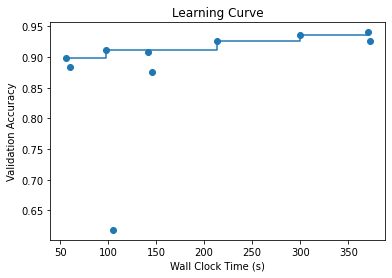

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Other Tasks

Besides sequence classification, FLAML currently also supports four other tasks (more tasks are to be supported, which can be found on FLAML's documentation website https://microsoft.github.io/FLAML/docs/Examples/AutoML-NLP):

- sequence regression: predicting a float number from the input sequence, e.g., predicting the rating of a hotel review based on the text content;
- token classification: predicting the label of each token in a sequence, e.g., named entity recognition;
- multiple choice: predicting the best second half of a sentence that comes next to the first part of a sentence based on common sensen reasoning. An example is seen below;
- (abstractive) summarization: generating the textual summarization of an input paragraph;

For each task, you only have to change the "Load data and preprocess" with the corresponding data loading process. For example:

### 3.1 Multiple Choice Example

Multiple choice is a task of predicting the best second half of a sentence that follows the first half based on common sense reasoning. An example of multiple-choice classification problem is:

On stage, a woman takes a seat at the piano. She
a) sits on a bench as her sister plays with the doll.
b) smiles with someone as the music plays.
c) is in the crowd, watching the dancers.
d) *nervously sets her fingers on the keys*.

In [12]:
from datasets import load_dataset

train_dataset = load_dataset("swag", split="train").to_pandas().iloc[:10000]
dev_dataset = load_dataset("swag", split="validation").to_pandas().iloc[:10000]
test_dataset = load_dataset("swag", split="test").to_pandas()

custom_sent_keys = [
        "sent1",
        "sent2",
        "ending0",
        "ending1",
        "ending2",
        "ending3",
        "gold-source",
        "video-id",
        "startphrase",
        "fold-ind",
    ]                                                  # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


In [7]:
train_dataset.iloc[0]["sent1"]

'Members of the procession walk down the street holding small horn brass instruments.'

In [13]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

if not ray.is_initialized():
    ray.init()

automl_settings = {
    "time_budget": 500,                 # setting the time budget
    "task": "multichoice-classification",       # setting the task as multiplechoice-classification
    "fit_kwargs_by_estimator": {          # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "ckpt_per_epoch": 1,           # setting the number of checkoints per epoch
            "per_device_eval_batch_size": 16, # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86157) {'eval_loss': 0.6315866112709045, 'eval_automl_metric': 0.18779999999999997, 'eval_runtime': 15.4883, 'eval_samples_per_second': 645.648, 'eval_steps_per_second': 40.353, 'epoch': 1.66}
(train pid=86157) {'train_runtime': 190.7625, 'train_samples_per_second': 87.254, 'train_steps_per_second': 10.909, 'train_loss': 0.5091343906738046, 'epoch': 1.66}
(train pid=86249) {'eval_loss': 1.2118068933486938, 'eval_automl_metric': 0.2015, 'eval_runtime': 15.2585, 'eval_samples_per_second': 655.374, 'eval_steps_per_second': 40.961, 'epoch': 2.87}


(train pid=86157) Using amp half precision backend
(train pid=86157) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: ending3, ending1, video-id, sent1, ending0, sent2, fold-ind, ending2, startphrase, gold-source. If ending3, ending1, video-id, sent1, ending0, sent2, fold-ind, ending2, startphrase, gold-source are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86157) ***** Running Prediction *****
(train pid=86157)   Num examples = 10000
(train pid=86157)   Batch size = 16


(train pid=86249) {'eval_loss': 1.2118068933486938, 'eval_automl_metric': 0.2015, 'eval_runtime': 15.1369, 'eval_samples_per_second': 660.639, 'eval_steps_per_second': 41.29, 'epoch': 2.87}
(train pid=86249) {'train_runtime': 546.3809, 'train_samples_per_second': 156.658, 'train_steps_per_second': 39.165, 'train_loss': 0.5030154804349909, 'epoch': 2.87}
(train pid=86195) {'loss': 0.4854, 'learning_rate': 1.3592147782116173e-06, 'epoch': 2.0}


(train pid=86249) Using amp half precision backend
(train pid=86249) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: fold-ind, sent2, gold-source, ending1, startphrase, sent1, ending0, video-id, ending2, ending3. If fold-ind, sent2, gold-source, ending1, startphrase, sent1, ending0, video-id, ending2, ending3 are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86249) ***** Running Prediction *****
(train pid=86249)   Num examples = 10000
(train pid=86249)   Batch size = 16


(train pid=86195) {'eval_loss': 0.49709731340408325, 'eval_automl_metric': 0.17600000000000005, 'eval_runtime': 15.4983, 'eval_samples_per_second': 645.232, 'eval_steps_per_second': 40.327, 'epoch': 2.0}


2022-03-19 14:41:56,719	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86195) {'eval_loss': 0.5254333019256592, 'eval_automl_metric': 0.17800000000000005, 'eval_runtime': 15.45, 'eval_samples_per_second': 647.251, 'eval_steps_per_second': 40.453, 'epoch': 3.0}
(train pid=86195) {'loss': 0.3989, 'learning_rate': 3.8051750127352887e-07, 'epoch': 3.0}


2022-03-19 14:42:56,729	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86195) {'eval_loss': 0.5254867076873779, 'eval_automl_metric': 0.17789999999999995, 'eval_runtime': 15.424, 'eval_samples_per_second': 648.341, 'eval_steps_per_second': 40.521, 'epoch': 3.0}
(train pid=86195) {'eval_loss': 0.5332269072532654, 'eval_automl_metric': 0.17830000000000001, 'eval_runtime': 15.4452, 'eval_samples_per_second': 647.45, 'eval_steps_per_second': 40.466, 'epoch': 3.39}
(train pid=86195) {'train_runtime': 382.2827, 'train_samples_per_second': 88.597, 'train_steps_per_second': 11.076, 'train_loss': 0.5299136270370808, 'epoch': 3.39}


2022-03-19 14:43:56,739	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86195) Using amp half precision backend
(train pid=86195) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: ending2, sent1, ending0, sent2, ending3, video-id, gold-source, ending1, startphrase, fold-ind. If ending2, sent1, ending0, sent2, ending3, video-id, gold-source, ending1, startphrase, fold-ind are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86195) ***** Running Prediction *****
(train pid=86195)   Num examples = 10000
(train pid=86195)   Batch size = 16
2022-03-19 14:44:14,271	INFO tune.py:639 -- Total run time: 795.18 seconds (504.18 seconds for the tuning loop).
[flaml.automl: 03-19 14:44:19] {2837} INFO - selected model: None
/data/installation/anaconda3/envs/tmp/lib

{'loss': 0.6603, 'learning_rate': 4.631567529441369e-06, 'epoch': 1.0}


[flaml.automl: 03-19 14:46:08] {2947} INFO - retrain transformer for 109.2s
[flaml.automl: 03-19 14:46:08] {2954} INFO - retrained model: None
[flaml.automl: 03-19 14:46:08] {2283} INFO - fit succeeded
[flaml.automl: 03-19 14:46:08] {2284} INFO - Time taken to find the best model: 319.927033662796


{'train_runtime': 96.899, 'train_samples_per_second': 245.031, 'train_steps_per_second': 30.63, 'train_loss': 0.6602518278346073, 'epoch': 1.0}


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 0.00021956991427751982, 'num_train_epochs': 0.3549576494055084, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07425273520338253, 'weight_decay': 0.03879221030529465, 'adam_epsilon': 3.7880482987985576e-08, 'seed': 43, 'global_max_steps': 444, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 0.00021956991427751982, 'num_train_epochs': 0.3549576494055084, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07425273520338253, 'weight_decay': 0.03879221030529465, 'adam_epsilon': 3.7880482987985576e-08, 'seed': 43, 'global_max_steps': 444, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, '

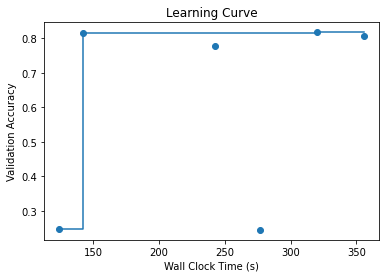

In [14]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### 3.2 Text Summarization Example

The text summarization task summarizes a long text into a short sentence. For example:

- Document: Army explosives experts were called out to deal with a suspect package at the offices on the Newtownards Road on Friday night. Roads were sealed off and traffic diverted as a controlled explosion was carried out. The premises, used by East Belfast MP Naomi Long, have been targeted a number of times. Most recently, petrol bomb attacks were carried out on the offices on consecutive nights in April and May. The attacks began following a Belfast City Council vote in December 2012 restricting the flying of the union flag at the City Hall. Condemning the latest hoax, Alliance MLA Chris Lyttle said: "It is a serious incident for the local area, it causes serious disruption, it puts people's lives at risk, it can prevent emergency services reaching the area. "Ultimately we need people with information to share that with the police in order for them to do their job and bring these people to justice.

- Summary: A suspicious package left outside an Alliance Party office in east Belfast has been declared a hoax.

In this example, we use FLAML to perform *abstractive summarization* using the t5-small language model, i.e., the summary is generated word-by-word. 

In [15]:
from datasets import load_dataset

train_dataset = load_dataset("xsum", split="train").to_pandas()
print(len(train_dataset))
dev_dataset = load_dataset("xsum", split="validation").to_pandas()
test_dataset = load_dataset("xsum", split="test").to_pandas()

custom_sent_keys = ["document"]       # specify the column names of the input sentences
label_key = "summary"                 # specify the column name of the label                              

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


204045


Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)
Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


In [16]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
if not ray.is_initialized():
    ray.init()

automl_settings = {
    "time_budget": 500,         # setting the time budget
    "task": "summarization",    # setting the task as summarization
    "fit_kwargs_by_estimator": {  # if model_path is not set, the default model is t5-small: https://huggingface.co/t5-small
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "ckpt_per_epoch": 1,    # setting the number of checkoints per epoch
            "model_path": "t5-small",
            "per_device_eval_batch_size": 16,  # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,  # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",  # set the file to save the log for HPO
    "log_type": "all",   # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},  # set whether to use Ray
    "metric": "rouge1",
    "n_concurrent_trials": 4,  # sample: False # if the time is sufficient (e.g., longer than one trial's running time), you can set 
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86232) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86232)   warnings.warn(


(train pid=86232) {'loss': 8.7635, 'learning_rate': 1.2308416834153697e-05, 'epoch': 0.11}


(train pid=86184) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86184)   warnings.warn(
(train pid=86225) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86225)   warnings.warn(
(train pid=86160) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.opti

(train pid=86232) {'eval_loss': 6.893245697021484, 'eval_automl_metric': 0.8537338408275918, 'eval_runtime': 102.2734, 'eval_samples_per_second': 110.801, 'eval_steps_per_second': 6.932, 'epoch': 0.11}


2022-03-19 14:57:00,687	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86184) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86184) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'eval_loss': 7.381210803985596, 'eval_automl_metric': 0.8475751825208984, 'eval_runtime': 107.4032, 'eval_samples_per_second': 105.509, 'eval_steps_per_second': 6.601, 'epoch': 0.16}


(train pid=86160) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86160) [nltk_data]   Package punkt is already up-to-date!
(train pid=86225) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86225) [nltk_data]   Package punkt is already up-to-date!


(train pid=86160) {'eval_loss': 10.150897979736328, 'eval_automl_metric': 0.8566791839938478, 'eval_runtime': 108.2143, 'eval_samples_per_second': 104.718, 'eval_steps_per_second': 6.552, 'epoch': 0.36}


2022-03-19 14:58:00,697	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86225) {'eval_loss': 11.665904998779297, 'eval_automl_metric': 0.858011676038827, 'eval_runtime': 109.4667, 'eval_samples_per_second': 103.52, 'eval_steps_per_second': 6.477, 'epoch': 0.38}


(train pid=86232) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86232) [nltk_data]   Package punkt is already up-to-date!


(train pid=86232) {'eval_loss': 6.893245697021484, 'eval_automl_metric': 0.8537338408275918, 'eval_runtime': 110.7246, 'eval_samples_per_second': 102.344, 'eval_steps_per_second': 6.403, 'epoch': 0.11}
(train pid=86232) {'train_runtime': 220.8946, 'train_samples_per_second': 4.648, 'train_steps_per_second': 0.149, 'train_loss': 8.763471198804451, 'epoch': 0.11}


2022-03-19 14:59:00,706	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86232) Using amp half precision backend
(train pid=86232) ***** Running Prediction *****
(train pid=86232)   Num examples = 11332
(train pid=86232)   Batch size = 16
(train pid=86184) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86184) [nltk_data]   Package punkt is already up-to-date!
(train pid=86160) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86160) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'eval_loss': 7.381210803985596, 'eval_automl_metric': 0.8475751825208984, 'eval_runtime': 109.1975, 'eval_samples_per_second': 103.775, 'eval_steps_per_second': 6.493, 'epoch': 0.16}


(train pid=86225) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86225) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'train_runtime': 232.9303, 'train_samples_per_second': 10.067, 'train_steps_per_second': 1.262, 'train_loss': 9.880440506280637, 'epoch': 0.16}
(train pid=86160) {'eval_loss': 10.150897979736328, 'eval_automl_metric': 0.8566791839938478, 'eval_runtime': 108.3182, 'eval_samples_per_second': 104.618, 'eval_steps_per_second': 6.546, 'epoch': 0.36}
(train pid=86160) {'train_runtime': 232.4568, 'train_samples_per_second': 92.218, 'train_steps_per_second': 2.887, 'train_loss': 11.215172903878349, 'epoch': 0.36}
(train pid=86225) {'eval_loss': 11.665904998779297, 'eval_automl_metric': 0.858011676038827, 'eval_runtime': 110.526, 'eval_samples_per_second': 102.528, 'eval_steps_per_second': 6.415, 'epoch': 0.38}
(train pid=86225) {'train_runtime': 236.6253, 'train_samples_per_second': 19.714, 'train_steps_per_second': 0.621, 'train_loss': 11.549961930614407, 'epoch': 0.38}


2022-03-19 15:00:00,942	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86184) Using amp half precision backend
(train pid=86184) ***** Running Prediction *****
(train pid=86184)   Num examples = 11332
(train pid=86184)   Batch size = 16
(train pid=86160) Using amp half precision backend
(train pid=86160) ***** Running Prediction *****
(train pid=86160)   Num examples = 11332
(train pid=86160)   Batch size = 16
(train pid=86225) Using amp half precision backend
(train pid=86225) ***** Running Prediction *****
(train pid=86225)   Num examples = 11332
(train pid=86225)   Batch size = 16
2022-03-19 15:01:00,948	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
2022-03-19 15:02:20,150	INFO tune.py:639 -- Total run time: 950.87 seconds (500.36 seconds for the tuning loop).
[flaml.automl: 03-19 15:02:25] {

{'train_runtime': 14.6848, 'train_samples_per_second': 13894.959, 'train_steps_per_second': 434.258, 'train_loss': 10.199760437011719, 'epoch': 0.02}


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 3.6439277745413994e-06, 'num_train_epochs': 0.454119690781029, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04654549348562217, 'weight_decay': 0.06669806327326033, 'adam_epsilon': 2.5833461668835812e-08, 'seed': 42, 'global_max_steps': 125, 'learner': 'transformer', 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 3.6439277745413994e-06, 'num_train_epochs': 0.454119690781029, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04654549348562217, 'weight_decay': 0.06669806327326033, 'adam_epsilon': 2.5833461668835812e-08, 'seed': 42, 'global_max_steps': 125, 'learner': 'transformer', 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, '

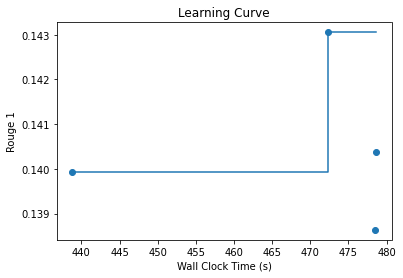

In [17]:

from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Rouge 1')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

In [18]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(["Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.\nWorkers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.\nThe Welsh Government said more people than ever were getting help to address housing problems.\nChanges to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.\nPrison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.\nHowever, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.\nAndrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the need for accommodation was 'chronic'.\n'There\'s a desperate need for it, finding suitable accommodation for those leaving prison there is just a lack of it everywhere,' he said.\n'It could take six months to a year, without a lot of help they could be on the streets for six months.\n'When you think of the consequences of either being on the street, especially with the cold weather at the moment or you may have a roof over your head, sometimes there is only one choice.'\nMr Stevens believes building more one-bedroom flats could help ease the problem.\n'The average price is a hundred pounds a week to keep someone in a rented flat, prison is a lot more than that so I would imagine it would save the public purse quite a few pounds,' he said.\nOfficial figures show 830 one-bedroom properties were built in the year to March 2016, of an overall total of 6,900 new properties in Wales.\nMarc, 50, who has been in and out of prison for the past 20 years for burglary offences, said he struggled to find accommodation each time he was released.\nHe said he would ask himself: 'Where am I going to stay? Where am I going to live? Have I got somewhere where I can see my daughter.'\n'You\'re put out among the same sort of people doing the same sort of thing, and it\'s difficult, it\'s difficult to get away from it. It\'s like every man for himself, there\'s nothing.'\nMarc has now found stable accommodation with homeless charity Emmaus and said it had been life changing.\n'You feel safe, you got hot food, you\'ve got company of people in similar situations to yourself but all dealing with different issues. It\'s a constructive, helpful atmosphere,' he said.\nTom Clarke, chief executive of Emmaus South Wales, agreed there was not enough support available.\n'We do still see [people] homeless on the streets, so clearly they haven\'t got accommodation and haven\'t got provision,' he said.\n'I think the key is connecting people with the services they need. I don\'t delude myself that Emmaus can offer a one size fits all for everyone, we can\'t.\n'But there must be other opportunities and given suitable encouragement I believe that can and should happen.'\nA Welsh Government spokesman said the national pathway for homeless services to children, young people and adults in the secure estate had prevented many people from losing their home whilst serving their prison sentence.\nIt added there were already significant demands for one-bedroom flats across the public and private sector and it was providing 20,000 new affordable homes in the next five years."])
print('Predicted labels', y_pred)

Using amp half precision backend
***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Predicted labels ['prison link Cymru said some ex-offenders were living rough for up to ']
